In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import collections
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pickle
from tqdm import tqdm
from pathlib import Path
import contextily as ctx
import seaborn as sns

random.seed(42)
np.random.seed(42)

In [2]:
### SET HYPERPARAMETERS ###
city = "nyc"
t_window = 210  # Training window in days
k_days = 7  # Epoch length in days
threshold = 100  # Performance degradation threshold (adjust as needed)
max_simulation_days = 104  # Maximum number of simulation days
topK = 20
algorithm = 'MultiVAE'
version = "full"
seed = 501

### ------------------- ###


In [3]:
basedir = pathlib.Path().cwd().parent

# Define base directory up to the version level
version_dir = basedir / 'out' / 'experiments' / version

simulated_temporal_colocation_net = {}

# Iterate over seed directories (0,1,...) inside the version directory
for seed_dir in version_dir.iterdir():
    #ensure it's a directory and only a number
    if not seed_dir.is_dir() or not seed_dir.name.isdigit():
        continue
    

    # Extract seed from folder name
    s = int(seed_dir.name)
    if s != seed:
        continue

    print(seed)
    # Define the colocation network simulation path inside each seed folder
    colocation_network_simulated_dir = (
        seed_dir / 'colocationnetworks' /
        f'city_{city}__train_{t_window}__step_{k_days}__max_{max_simulation_days}__topK_{topK}__alg_{algorithm}'
    )

    if not colocation_network_simulated_dir.exists():
        continue  # Skip if the directory doesn't exist

    for file_path in tqdm(colocation_network_simulated_dir.iterdir()):
        if file_path.name.endswith(".gpickle"):
            rec_prob = float(file_path.name.split("_")[1])
            epoch = int(file_path.name.split("_")[3].split(".")[0])

            # Initialize dictionary structure
            if seed not in simulated_temporal_colocation_net:
                simulated_temporal_colocation_net[seed] = {}
            if rec_prob not in simulated_temporal_colocation_net[seed]:
                simulated_temporal_colocation_net[seed][rec_prob] = {}

            # Load the graph
            with open(file_path, "rb") as f:
                simulated_temporal_colocation_net[seed][rec_prob][epoch] = pickle.load(f)


501


105it [00:00, 791.26it/s]


In [4]:
# Define probability values in a list for easy reference
probabilities = [0.0, 1.0]

# Create a dictionary to store all networks
colocation_nets = {p: simulated_temporal_colocation_net[seed][p] for p in probabilities}

def collapse_temporal_networks(networks):
    networks = list(networks.values())
    G = networks[0].copy()
    for i in range(1, len(networks)):
        G = nx.compose(G, networks[i])
    return G

agg_networks_dict = {
    0.0: collapse_temporal_networks(colocation_nets[0.0]),
    1.0: collapse_temporal_networks(colocation_nets[1.0])
}

In [5]:
def compute_degree_distribution(G):
    # Get degrees
    degrees = [d[1] for d in G.degree()]
    # Count frequency of each degree
    degree_count = collections.Counter(degrees)
    
    # Sort by degree
    x = sorted(degree_count.keys())
    y = [degree_count[k] / float(len(degrees)) for k in x]  # Normalized frequency
    
    return x, y

# Store all distribution data to find global min/max for both axes
all_distributions = []

# Debug information
for i, AggG in agg_networks_dict.items():
    x, y = compute_degree_distribution(AggG)
    print(len(x), len(y))
    all_distributions.append((x, y))

32 32
307 307


In [6]:
from collections import defaultdict
from pathlib import Path
from tqdm.notebook import tqdm
ps = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
new_columns = ['uid', 'lat', 'lon', 'venueID', 'venue_descr', 'time', 'city_name', 'First_Category', 'Second_Category', 'step', 'epoch', 'city', 'simulation_state']
#trajectories_dict is a dictionary in which the first level key is the probability p and the second level key is the algorithm. Then it stores the trajectories dataframe
trajectories_dict = defaultdict(lambda: defaultdict())

for p in tqdm(ps):
        
    experiment_dir = f"../data/processed/experiments/{version}/{seed}/city_{city}__train_{t_window}__step_{k_days}__max_{max_simulation_days}__topK_{topK}__alg_{algorithm}__recProb_{p}"
    merged_user_histories = pd.DataFrame()

    for user_fname in Path(experiment_dir).glob('user_histories/*.csv'):
        user_id = user_fname.stem.split('_')[0]
        user_history = pd.read_csv(user_fname, index_col=0)
        if 'simulation_state' not in user_history.columns:
            #print('skipping userid', user_id)
            continue
        user_history.columns = new_columns
        #keep only the rows that have simulation_state not Nan
        user_history = user_history[user_history['simulation_state'].notnull()]
        merged_user_histories = pd.concat([merged_user_histories, user_history], ignore_index=True)
        trajectories_dict[p][algorithm] = merged_user_histories
            
        

  0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
#%%script false --no-raise-error
# Include your create_network_layout, sample_common_nodes and plot_networks functions here.
def create_network_layout(network, rich_count=15, rich_radius=0.25, peripheral_radius=0.48):
    #Your create_network_layout function...
    all_nodes = list(network.nodes())
    
    if not all_nodes:
        return {}, ([], [])
    
    # Get the degrees of all nodes
    node_degrees = {node: network.degree(node) for node in all_nodes}
    
    # Sort nodes by degree (highest first) and take the top N
    sorted_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)
    
    # Take top rich_count nodes (or all if fewer than rich_count)
    rich_club_nodes = [node for node, _ in sorted_nodes[:min(rich_count, len(sorted_nodes))]]
    peripheral_nodes = [node for node in all_nodes if node not in rich_club_nodes]
    
    # Create layout
    layout = {}
    
    # Circular positions for peripheral nodes
    angle_step = 2 * np.pi / max(1, len(peripheral_nodes))  # Prevent division by zero
    for i, node in enumerate(peripheral_nodes):
        angle = i * angle_step
        x = 0.5 + peripheral_radius * np.cos(angle)  # Keep within [0,1] range
        y = 0.5 + peripheral_radius * np.sin(angle)
        layout[node] = np.array([x, y])
    
    # Center positions for rich club nodes - arrange in a smaller circle
    rich_angle_step = 2 * np.pi / max(1, len(rich_club_nodes))  # Prevent division by zero
    for i, node in enumerate(rich_club_nodes):
        angle = i * rich_angle_step
        x = 0.5 + rich_radius * np.cos(angle)  # Smaller radius for rich club nodes
        y = 0.5 + rich_radius * np.sin(angle)
        layout[node] = np.array([x, y])
    
    return layout, (rich_club_nodes, peripheral_nodes)

def sample_common_nodes(networks_dict, n_samples=100):
    common_nodes = set.intersection(*[set(net.nodes()) for net in networks_dict.values()])
    
    if not common_nodes:
        return []
    
    random.seed(46)
    np.random.seed(46)

    #Convert to sorted list to ensure consistent ordering before sampling
    sorted_nodes = sorted(list(common_nodes))
    
    if len(sorted_nodes) <= n_samples:
        return sorted_nodes
    else:
        return list(np.random.choice(sorted_nodes, size=n_samples, replace=False))

def plot_networks(networks_dict, ax, suptitle="", node_color='lightblue', rich_node_color='#FF9999', 
                 sample_size=100, rich_count=15, edge_width_multiplier=1.0,
                 rich_edge_color='#FF0000', peripheral_edge_color='#CCCCCC', common_nodes=None, squared=False, save_path=None):
    #Your plot_networks function...
    if not networks_dict:
        raise ValueError("The networks_dict is empty. Provide at least one network to plot.")

    num_networks = len(networks_dict)
    if num_networks > 6:
        raise ValueError("This function is designed to plot up to 6 networks (2 rows × 3 columns).")
    
    # Create subgraphs with only the sampled nodes
    sampled_networks = {}
    for key, net in networks_dict.items():
        sampled_networks[key] = net.subgraph(common_nodes)
    
    # Sort networks by key (e.g., time period names) to maintain order
    sorted_keys = sorted(sampled_networks.keys())

    # Loop through the available networks
    for idx, key in enumerate(sorted_keys):
        network = sampled_networks[key]

        # Set subplot background to white
        ax.set_facecolor('white')

        # Create layout for this specific network and get rich club info
        pos, (rich_nodes, peripheral_nodes) = create_network_layout(
            network, rich_count=rich_count
        )
        
        # Count different types of edges
        rich_edges = []
        peripheral_edges = []
        mixed_edges = []
        
        for u, v in network.edges():
            if u in rich_nodes and v in rich_nodes:
                rich_edges.append((u, v))
            elif u in peripheral_nodes and v in peripheral_nodes:
                peripheral_edges.append((u, v))
            else:
                mixed_edges.append((u, v))
        
        # Draw different types of edges with different colors and widths
        # Regular edges first (peripheral and mixed with same color)
        regular_edges = peripheral_edges + mixed_edges
        nx.draw_networkx_edges(network, pos, ax=ax, edgelist=regular_edges,
                              edge_color=peripheral_edge_color, 
                              width=0.8 * edge_width_multiplier, alpha=0.5)
        
        # Rich club edges on top (thicker, red, no alpha)
        nx.draw_networkx_edges(network, pos, ax=ax, edgelist=rich_edges,
                              edge_color=rich_edge_color, 
                              width=1.5 * edge_width_multiplier, alpha=1.0)

        # Draw rich club nodes (red)
        if rich_nodes:
            nx.draw_networkx_nodes(network, pos, ax=ax, nodelist=rich_nodes,
                                  node_color=rich_node_color, 
                                  edgecolors="#800020", node_size=340, linewidths=2)

        
        # Draw peripheral nodes (blue)
        if peripheral_nodes:
            nx.draw_networkx_nodes(network, pos, ax=ax, nodelist=peripheral_nodes,
                                  node_color=node_color, 
                                  edgecolors=None, node_size=110, alpha = 0.6 )

        # Calculate rich club density
        rich_club_density = 0
        if len(rich_nodes) > 1:
            potential_rich_edges = len(rich_nodes) * (len(rich_nodes) - 1) / 2
            rich_club_density = len(rich_edges) / potential_rich_edges if potential_rich_edges > 0 else 0
            
        # Calculate peripheral density (excluding rich club connections)
        peripheral_density = 0
        if len(peripheral_nodes) > 1:
            potential_peripheral_edges = len(peripheral_nodes) * (len(peripheral_nodes) - 1) / 2
            peripheral_density = len(peripheral_edges) / potential_peripheral_edges if potential_peripheral_edges > 0 else 0
        
        # Set the main title only
        # Set the main title with larger font size
        ax.set_title("")  # Increase font size here

        # Add the metrics text directly using set_title but with smaller font
        metrics_text = f'PD: {peripheral_density:.2f}, '
        metrics_text += f'RD: {rich_club_density:.2f}'

        # Add as a subtitle with smaller font size
        ax.text(0.5, 0.82, metrics_text, 
                horizontalalignment='center', 
                verticalalignment='top',
                transform=ax.transAxes, 
                fontsize=18)  # Smaller font size here

        # Set axis properties
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        if squared:
            ax.set_aspect('equal')

    # Create a custom legend
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    
    # Create a custom legend with circles instead of rectangles
    from matplotlib.lines import Line2D
    
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=rich_node_color, 
              markeredgecolor='black', markersize=15, label='Rich nodes'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=node_color, 
              markeredgecolor='black', markersize=15, label='Other nodes'),
        Line2D([0], [0], color=rich_edge_color, lw=2, label='Rich-Rich connections'),
        Line2D([0], [0], color=peripheral_edge_color, lw=0.5, label='Other connections')
    ]
    
    # # Place legend at the bottom of the figure
    # fig.legend(handles=legend_elements, loc='lower center', 
    #           bbox_to_anchor=(0.5, -0.0), ncol=2, fontsize=18)

    # Adjust layout to make room for the legend
    plt.suptitle(f"{algorithm}", fontsize=28, fontweight='bold')
    #plt.subplots_adjust(bottom=0.04)
    plt.tight_layout()


Common nodes: ['1003', '1012', '1021', '1027', '1043', '1047', '1049', '1058', '1060', '1071', '1075', '1076', '111', '114', '121', '133', '137', '147', '149', '153', '157', '159', '160', '175', '187', '198', '215', '22', '233', '241', '254', '265', '273', '283', '301', '320', '34', '343', '349', '354', '359', '36', '361', '378', '39', '400', '403', '416', '419', '429', '447', '452', '457', '462', '484', '486', '490', '506', '548', '571', '588', '589', '594', '602', '619', '621', '642', '648', '649', '662', '668', '679', '68', '70', '732', '733', '742', '746', '748', '751', '767', '773', '801', '809', '816', '825', '837', '869', '879', '890', '892', '897', '904', '908', '917', '919', '925', '93', '932', '936', '942', '959', '960', '966', '973', '978', '98', '980', '982', '992']


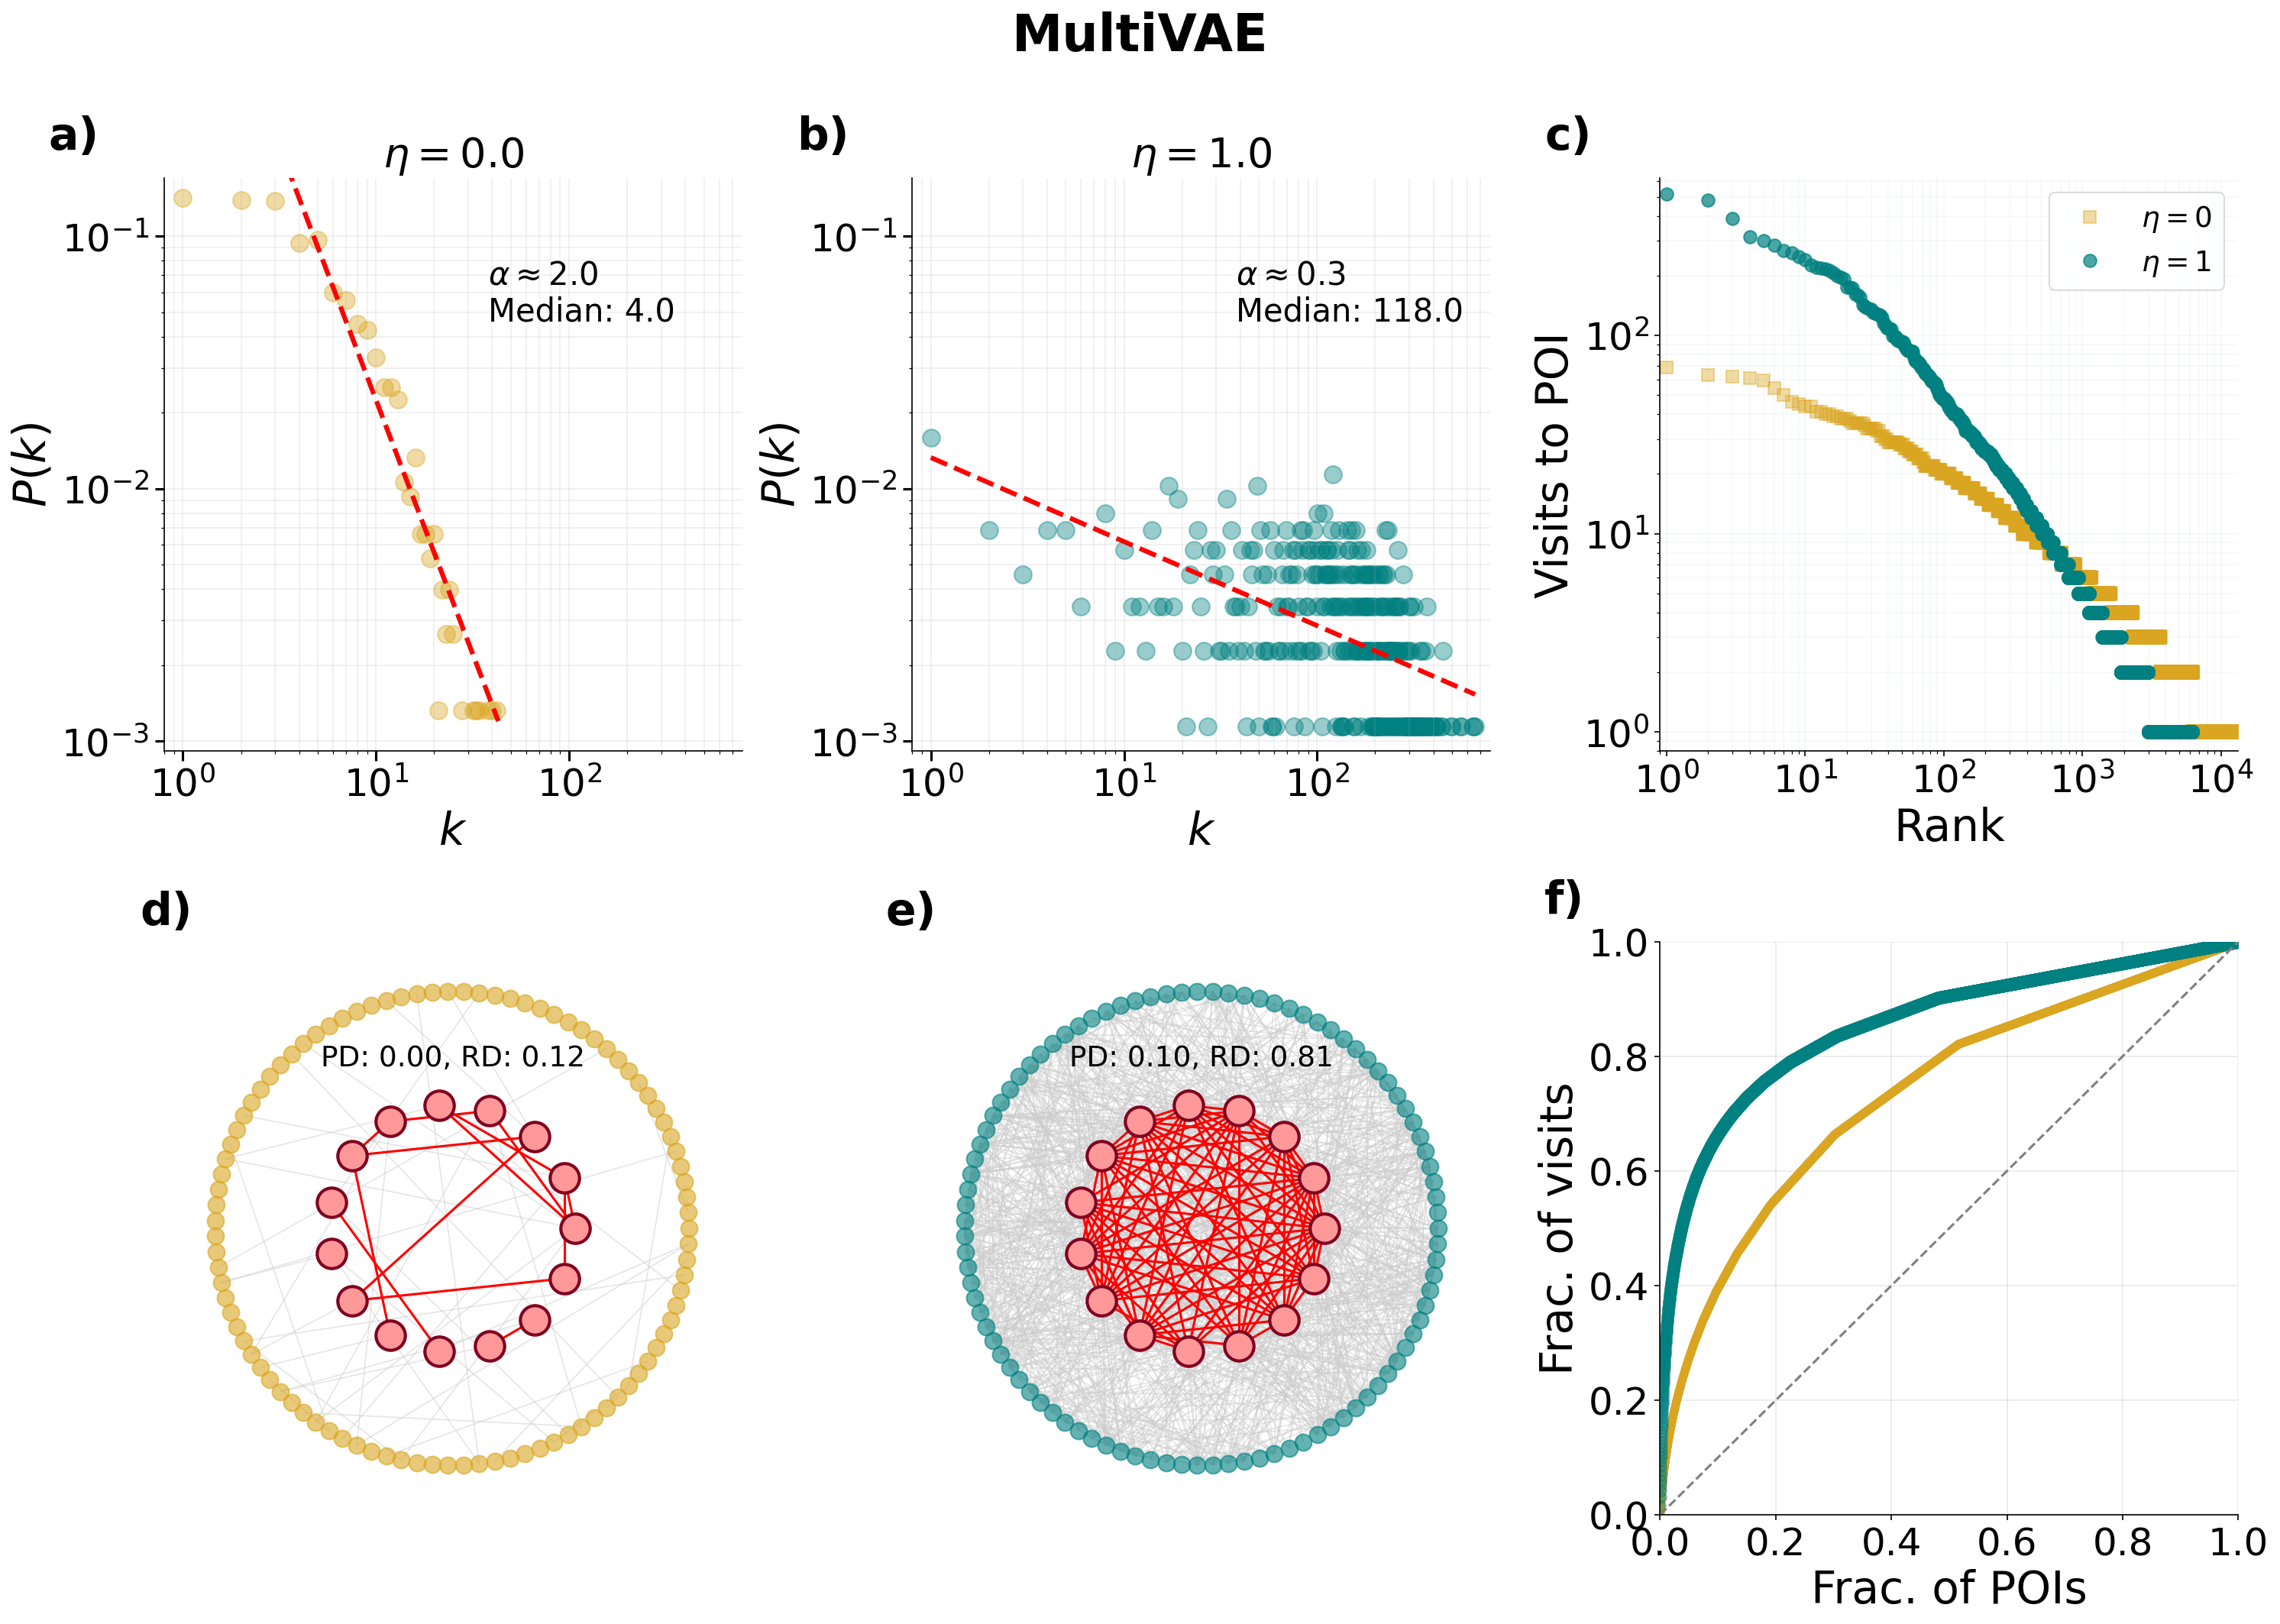

In [ ]:
#%%script false --no-raise-error
def create_combined_plot_final(agg_networks_dict, all_distributions, algorithm, trajectories_dict):
    """
    Creates a combined 2x3 plot with degree distributions on the top row, 
    network visualizations on the middle row, power law and lorenz on the right column.
    """

    fig, axs = plt.subplots(2, 3, figsize=(20, 14), dpi=150)  # Changed to 2x3
    plt.subplots_adjust(wspace=0.3, hspace=0.1)

    networks = list(agg_networks_dict.values())
    ps = list(agg_networks_dict.keys())

    # --- Plot 1: Degree Distribution (Top Left, p=0) ---
    def plot_degree_distribution_subplot(all_distributions, ax, p_index):
        x, y = all_distributions[p_index]
        AggG = networks[p_index]
        p = ps[p_index]

        global_y_min = min([min(y_val) for _, y_val in all_distributions if len(y_val) > 0])
        global_y_max = max([max(y_val) for _, y_val in all_distributions if len(y_val) > 0])
        global_x_min = min([min(x_val) for x_val, _ in all_distributions if len(x_val) > 0])
        global_x_max = max([max(x_val) for x_val, _ in all_distributions if len(x_val) > 0])

        if p_index == 0:
            color = "goldenrod"
        else:
            color = "teal"
        ax.scatter(x, y, marker='o', alpha=0.4, s=120, c=color)
        ax.set_title(f'$\eta = {p}$', fontsize=26, pad=7)

        ax.set_xlabel("$k$", size=28)
        ax.set_ylabel("$P(k)$", size=28)
        ax.tick_params(axis='both', which='major', labelsize=24)
        ax.tick_params(width=1.5, length=6)

        log_x = np.log10(np.array(x) + 1)
        log_y = np.log10(np.array(y) + 1e-10)

        mask = np.isfinite(log_x) & np.isfinite(log_y)
        if np.sum(mask) >= 3:
            z = np.polyfit(log_x[mask], log_y[mask], 1)
            p_fit = np.poly1d(z)
            x_fit = np.logspace(np.log10(min(x)), np.log10(max(x) + 1), 100)
            y_fit = 10**p_fit(np.log10(x_fit))
            ax.plot(x_fit, y_fit, 'r--', linewidth=3)

            gamma = -z[0]

            degrees = np.array([d[1] for d in AggG.degree()])
            median_degree = np.median(degrees)
            ax.text(0.56, 0.75, f"$\\alpha \\approx {gamma:.1f}$\nMedian: {median_degree:.1f}",
                    transform=ax.transAxes, size=20)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim(global_y_min * 0.8, global_y_max * 1.2)
        ax.set_xlim(global_x_min * 0.8, global_x_max * 1.2)
        ax.grid(True, which="both", ls="-", alpha=0.2)
        #remove upper and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)


    plot_degree_distribution_subplot(all_distributions, axs[0, 0], 0)

    # --- Plot 2: Degree Distribution (Top Right, p=1) ---
    plot_degree_distribution_subplot(all_distributions, axs[0, 1], 1)
    
    #axs[0,1].set_ylabel("")
    #axs[0,1].set_yticklabels([])
 

    # --- Plot 3: Network Visualization (Bottom Left, p=0) ---
    #print(sorted(list(agg_networks_dict[0].nodes())))
    common_nodes = sample_common_nodes(agg_networks_dict, n_samples=110)
    print("Common nodes:", sorted(common_nodes))
    plot_networks({ps[0]: networks[0]}, ax=axs[1, 0], node_color="goldenrod", sample_size=110, rich_count=15, common_nodes=common_nodes, squared=True)

    # --- Plot 4: Network Visualization (Bottom Right, p=1) ---
    plot_networks({ps[1]: networks[1]}, ax=axs[1, 1], node_color="teal", sample_size=110, rich_count=15, common_nodes=common_nodes, squared=True)

    # Set the y-limits of the network plots to be equal
    ymin = min(ax.get_ylim()[0] for ax in axs[1, :])
    ymax = max(ax.get_ylim()[1] for ax in axs[1, :])
    for ax in axs[1, :]:
        ax.set_ylim(ymin, ymax)

    # --- Plot 5: Power Law (Top Right) ---
    sorted_visits_p0 = trajectories_dict[0][algorithm].groupby('venueID').size().sort_values(ascending=False)
    sorted_visits_p1 = trajectories_dict[1][algorithm].groupby('venueID').size().sort_values(ascending=False)

    ranks_p0 = np.arange(1, len(sorted_visits_p0) + 1)
    ranks_p1 = np.arange(1, len(sorted_visits_p1) + 1)

    colors = ["goldenrod", "teal"]

    y_min = min(sorted_visits_p0.min(), sorted_visits_p1.min())
    y_max = max(sorted_visits_p0.max(), sorted_visits_p1.max())
    x_max = max(len(sorted_visits_p0), len(sorted_visits_p1))

    y_min = 0.8 * y_min
    y_max = 1.2 * y_max

    axs[0,2].loglog(ranks_p0, sorted_visits_p0.values, 
             marker="s", 
             color=colors[0],
             markersize=8,
             alpha=0.4,
             linewidth=0,
             label=r'$\eta = 0$')

    axs[0,2].loglog(ranks_p1, sorted_visits_p1.values, 
             marker="o", 
             color=colors[1],
             markersize=8,
             alpha=0.7,
             linewidth=0,
             label=r'$\eta = 1$')

    axs[0,2].set_xlim(0.9, x_max * 1.1)
    axs[0,2].set_ylim(y_min, y_max)
    axs[0,2].grid(True, which="both", ls="-", alpha=0.05, color='#6c757d')
    axs[0,2].tick_params(axis='both', which='major', labelsize=24)
    axs[0,2].set_xlabel('Rank', fontsize=28)
    axs[0,2].set_ylabel('Visits to POI', fontsize=28)
    axs[0,2].set_title("")
    axs[0,2].legend(fontsize=18, framealpha=0.7)
    #remove upper and right spines
    axs[0,2].spines['top'].set_visible(False)
    axs[0,2].spines['right'].set_visible(False)

    # --- Plot 6: Lorenz (Bottom Right) ---
    sorted_visits_p0 = trajectories_dict[0][algorithm].groupby('venueID').size().sort_values(ascending=False)
    sorted_visits_p1 = trajectories_dict[1][algorithm].groupby('venueID').size().sort_values(ascending=False)

    cumulative_visits_p0 = np.cumsum(sorted_visits_p0.values) / sorted_visits_p0.values.sum()
    cumulative_visits_p1 = np.cumsum(sorted_visits_p1.values) / sorted_visits_p1.values.sum()

    fractional_venues_p0 = np.linspace(0, 1, len(sorted_visits_p0))
    fractional_venues_p1 = np.linspace(0, 1, len(sorted_visits_p1))

    axs[1,2].plot(fractional_venues_p0, cumulative_visits_p0, 
            marker="o", 
            color=colors[0],
            markersize=4,
            alpha=0.7,
            linewidth=1,
            label=r"$\eta = 0.0$")

    axs[1,2].plot(fractional_venues_p1, cumulative_visits_p1, 
            marker="o", 
            color=colors[1],
            markersize=7,
            alpha=0.4,
            linewidth=1,
            label=r"$\eta = 1.0$")

    axs[1,2].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Equality')
    axs[1,2].set_xlim(0, 1)
    axs[1,2].set_ylim(0, 1)
    axs[1,2].grid(True, which="both", ls="-", alpha=0.15, color='#6c757d')
    axs[1,2].tick_params(axis='both', which='major', labelsize=24)
    #force xticks to be 0, 0.2, 0.4, 0.6, 0.8, 1. Only one decimal
    axs[1,2].set_xticks(np.arange(0, 1.1, 0.2))
    axs[1,2].set_xticklabels([f"{i:.1f}" for i in np.arange(0, 1.1, 0.2)], fontsize=24)

    axs[1,2].set_xlabel('Frac. of POIs', fontsize=28)
    axs[1,2].set_ylabel('Frac. of visits', fontsize=28)
    axs[1,2].set_title(f"")
    #axs[1,2].legend(fontsize=16, framealpha=0.7)
    #remove upper and right spines
    axs[1,2].spines['top'].set_visible(False)
    axs[1,2].spines['right'].set_visible(False)


    #text as title in each subplot (letter a, b, c, d, e, f)
    letters = ['a', 'b', 'c', 'd', 'e', 'f']
    for i, ax in enumerate(axs.flat):
        if i not in [3,4]:
            ax.text(-0.20, 1.11, f"{letters[i]})", transform=ax.transAxes, 
                fontsize=28, fontweight='bold', va='top', ha='left', color='black')
        else:
            ax.text(-0.05, 1.09, f"{letters[i]})", transform=ax.transAxes, 
                fontsize=28, fontweight='bold', va='top', ha='left', color='black')
            


    plt.tight_layout()
    plt.suptitle(f"{algorithm}", fontsize=32, fontweight='bold', y=1.009)
    plt.savefig(f"figures/{algorithm}_combined_plot.pdf", bbox_inches='tight', dpi=300)
    plt.show()



# Example usage:
create_combined_plot_final(agg_networks_dict, all_distributions, algorithm, trajectories_dict)

In [9]:

def gini_index(values):
    sorted_values = np.sort(values)
    n = len(sorted_values)
    
    if n == 0 or np.sum(sorted_values) == 0:
        return 0
    
    indices = np.arange(1, n + 1)
    gini = (2 * np.sum(indices * sorted_values)) / (n * np.sum(sorted_values)) - (n + 1) / n
    
    return gini

def load_user_history(experiment_dir, user_id, new_columns):
    """Loads a user's history, handles missing 'simulation_state', and cleans columns."""
    user_fname = Path(experiment_dir) / 'user_histories' / f'{user_id}_history.csv'
    if not user_fname.exists():
        return None

    user_history = pd.read_csv(user_fname, index_col=0)

    if 'simulation_state' not in user_history.columns:
        return None

    user_history.columns = new_columns
    user_history = user_history[user_history['simulation_state'].notnull()]
    return user_history

def get_users_with_50_plus_points(experiment_dir, new_columns, bounds):
    """Calculates and returns a list of user IDs with 150 or more points within the given bounds."""
    user_files = list(Path(experiment_dir).glob('user_histories/*.csv'))
    users_50_plus = []

    for user_fname in user_files:
        user_id = user_fname.stem.split('_')[0]
        user_history = pd.read_csv(user_fname, index_col=0)

        if 'simulation_state' not in user_history.columns:
            continue

        user_history.columns = new_columns
        user_history = user_history[user_history['simulation_state'].notnull()]
        #DROP duplicate lat/lon
        user_history = user_history.drop_duplicates(subset=['lat', 'lon'])
        within_bounds = user_history[
            (user_history['lat'] >= bounds['lat_min']) &
            (user_history['lat'] <= bounds['lat_max']) &
            (user_history['lon'] >= bounds['lon_min']) &
            (user_history['lon'] <= bounds['lon_max'])
        ]

        if len(within_bounds) >= 50:
            users_50_plus.append(user_id)

    return users_50_plus

def plot_user_visits(ax, user_history, cmap, vmin, vmax, p_v=1):
    """Plots user visits as scatter points, with size and color indicating frequency."""
    if user_history is not None and not user_history.empty:
        counts = user_history.groupby(['lon', 'lat']).size().reset_index(name='visits')

        gini_counts = gini_index(counts['visits'])

        counts['marker_size'] = 110 + 330 * (counts['visits'] - vmin) / (vmax - vmin) if vmax > vmin else 110

        # Sort values so larger points are plotted on top
        counts = counts.sort_values(by="visits", ascending=True)

        edgecolor = 'red'
        
        scatter = ax.scatter(counts['lon'], counts['lat'], s=counts['marker_size'], c=counts['visits'], cmap=cmap, alpha=0.95, edgecolor=edgecolor, linewidth=0.4, vmin=vmin, vmax=vmax)
        #add text with gini index
        ax.text(0.8, 0.95, f"Gini: {gini_counts:.2f}", transform=ax.transAxes, fontsize=16, ha='center', va='top', color='black', bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round'))
        # Add colorbar
        return scatter
    elif user_history is None:
        print("User history is missing or incomplete.")
    else:
        print("User history is empty.")
    return None

def load_and_merge_active_user_histories(experiment_dir, new_columns, user_ids):
    """Loads and merges user histories for the given user IDs."""
    merged_user_histories = pd.DataFrame()

    for user_fname in Path(experiment_dir).glob('user_histories/*.csv'):
        user_id = user_fname.stem.split('_')[0]
        if user_id not in user_ids:
            continue

        user_history = pd.read_csv(user_fname, index_col=0)

        if 'simulation_state' not in user_history.columns:
            continue

        user_history.columns = new_columns
        user_history = user_history[user_history['simulation_state'].notnull()]
        merged_user_histories = pd.concat([merged_user_histories, user_history], ignore_index=True)

    return merged_user_histories

def plot_collective_visits(ax, location_counts, cmap, vmin, vmax, min_threshold=1, p_v=1):
    """Plots collective visits with shared scale and a minimum visit threshold."""
    if not location_counts.empty:
        location_counts = location_counts[location_counts['visits'] >= min_threshold]  # Apply threshold
        gini_counts = gini_index(location_counts['visits'])

        if not location_counts.empty:

            location_counts['marker_size'] = 110 + 330 * (location_counts['visits'] - vmin) / (vmax - vmin) if vmax > vmin else 110

            # Sort values so larger points are plotted on top
            location_counts = location_counts.sort_values(by="visits", ascending=True)

            edgecolor = 'dodgerblue'
            scatter = ax.scatter(location_counts['lon'], location_counts['lat'], s=location_counts['marker_size'], c=location_counts['visits'], cmap=cmap, alpha=0.95, edgecolor=edgecolor, linewidth=0.4, vmin=vmin, vmax=vmax)

            # Add text with Gini index
            ax.text(0.8, 0.95, f"Gini: {gini_counts:.2f}", transform=ax.transAxes, fontsize=16, ha='center', va='top', color='black',  bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round'))

            # Add colorbar
            return scatter
        else:
            print(f"No collective visit data above threshold {min_threshold}.")
    else:
        print("No collective visit data.")
    return None


In [10]:
#%%script false --no-raise-error

# --- MAIN ---
new_columns = ['uid', 'lat', 'lon', 'venueID', 'venue_descr', 'time', 'city_name', 'First_Category', 'Second_Category', 'step', 'epoch', 'city', 'simulation_state']

nyc_bounds = {
    'lat_min': 40.69,
    'lat_max': 40.80,
    'lon_min': -74.02,
    'lon_max': -73.92
}

# Assuming version, seed, city, t_window, k_days, max_simulation_days, topK, algorithm are defined elsewhere.

p = 0.0
experiment_dir_p0 = f"../data/processed/experiments/{version}/{seed}/city_{city}__train_{t_window}__step_{k_days}__max_{max_simulation_days}__topK_{topK}__alg_{algorithm}__recProb_{p}"
user_files_p0 = list(Path(experiment_dir_p0).glob('user_histories/*.csv'))
user_ids_p0 = {fname.stem.split('_')[0] for fname in user_files_p0}

p = 1.0
experiment_dir_p1 = f"../data/processed/experiments/{version}/{seed}/city_{city}__train_{t_window}__step_{k_days}__max_{max_simulation_days}__topK_{topK}__alg_{algorithm}__recProb_{p}"
user_files_p1 = list(Path(experiment_dir_p1).glob('user_histories/*.csv'))
user_ids_p1 = {fname.stem.split('_')[0] for fname in user_files_p1}

populed_users = get_users_with_50_plus_points(experiment_dir_p0, new_columns, nyc_bounds)

random_user_id = populed_users[9]

user_history_p0 = load_user_history(experiment_dir_p0, random_user_id, new_columns)
user_history_p1 = load_user_history(experiment_dir_p1, random_user_id, new_columns)

shared_user_ids = sorted(list(user_ids_p0.intersection(user_ids_p1)))
sorted_shared_user_ids = sorted(shared_user_ids) #sort the list
random.seed(49)
sampled_shared_user_ids = random.sample(shared_user_ids, min(250, len(sorted_shared_user_ids)))


merged_user_histories_p0 = load_and_merge_active_user_histories(experiment_dir_p0, new_columns, sampled_shared_user_ids)
location_counts_p0 = merged_user_histories_p0.groupby(['lat', 'lon']).size().reset_index(name='visits')

merged_user_histories_p1 = load_and_merge_active_user_histories(experiment_dir_p1, new_columns, sampled_shared_user_ids)
location_counts_p1 = merged_user_histories_p1.groupby(['lat', 'lon']).size().reset_index(name='visits')

individual_vmin = min(user_history_p0.groupby(['lon', 'lat']).size().min(), user_history_p1.groupby(['lon', 'lat']).size().min())
individual_vmax = max(user_history_p0.groupby(['lon', 'lat']).size().max(), user_history_p1.groupby(['lon', 'lat']).size().max())

collective_vmin = min(location_counts_p0['visits'].min(), location_counts_p1['visits'].min())
collective_vmax = max(location_counts_p0['visits'].max(), location_counts_p1['visits'].max())


# Calculate individual Gini
ps = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
individual_gini_dict = {}
for p in ps:
    experiment_dir = f"../data/processed/experiments/{version}/{seed}/city_{city}__train_{t_window}__step_{k_days}__max_{max_simulation_days}__topK_{topK}__alg_{algorithm}__recProb_{p}"
    user_history = load_user_history(experiment_dir, random_user_id, new_columns)
    if user_history is not None and not user_history.empty:
        individual_gini_dict[p] = gini_index(user_history.groupby('venueID').size())
    else:
        individual_gini_dict[p] = 0

# Calculate collective Gini
collective_gini_dict = {}
for p in ps:
    experiment_dir = f"../data/processed/experiments/{version}/{seed}/city_{city}__train_{t_window}__step_{k_days}__max_{max_simulation_days}__topK_{topK}__alg_{algorithm}__recProb_{p}"
    
    # Use the same sample of users consistently
    merged_user_histories = load_and_merge_active_user_histories(experiment_dir, new_columns, sampled_shared_user_ids)
    
    # Apply the same filtering as in plot_collective_visits
    if not merged_user_histories.empty:
        # Group by lat, lon (same as in plot_collective_visits)
        location_counts = merged_user_histories.groupby(['lat', 'lon']).size().reset_index(name='visits')
        
        # Apply the same threshold as used in plot_collective_visits (min_threshold=3)
        location_counts = location_counts[location_counts['visits'] >= 3]
        
        if not location_counts.empty:
            collective_gini_dict[p] = gini_index(location_counts['visits'])
        else:
            collective_gini_dict[p] = 0
    else:
        collective_gini_dict[p] = 0


/tmp/ipykernel_1926592/345879321.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_counts['marker_size'] = 110 + 330 * (location_counts['visits'] - vmin) / (vmax - vmin) if vmax > vmin else 110
/tmp/ipykernel_1926592/345879321.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_counts['marker_size'] = 110 + 330 * (location_counts['visits'] - vmin) / (vmax - vmin) if vmax > vmin else 110
/home/gmauro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_i

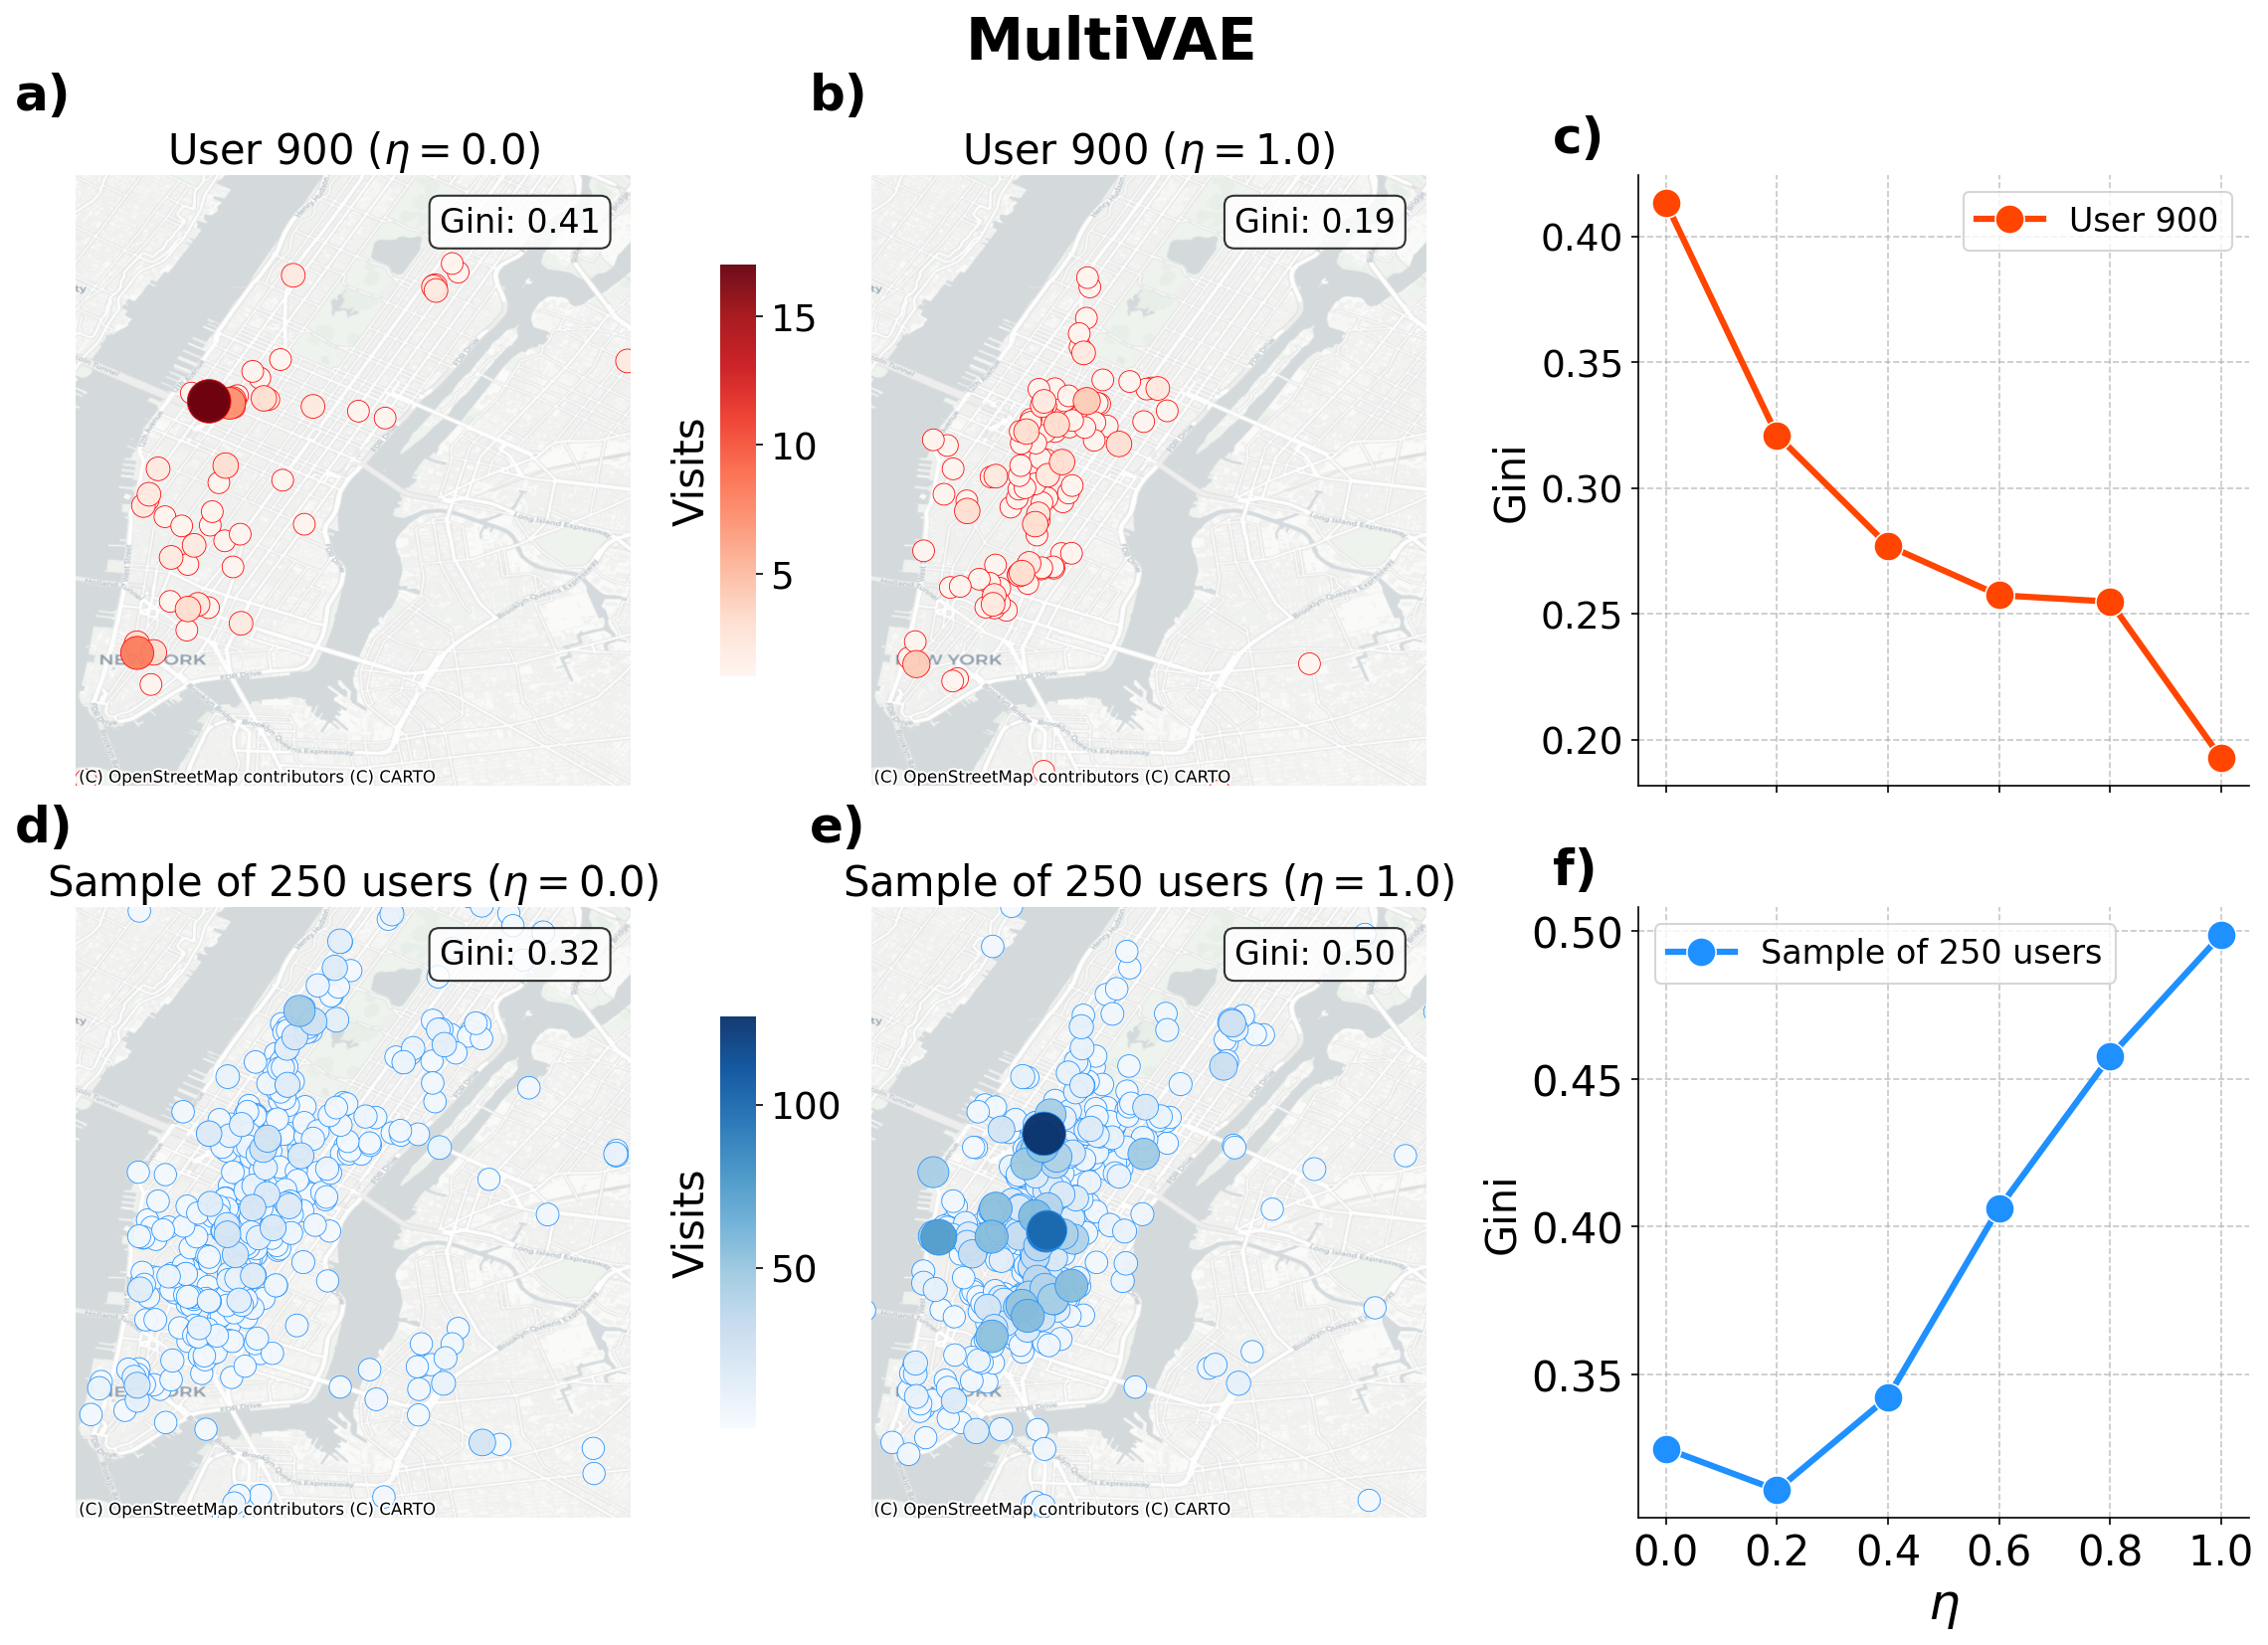

In [ ]:
#%%script false --no-raise-error

# --- Create figure ---
fig = plt.figure(figsize=(20, 12), dpi=150)

# --- Define grid for main plots ---
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1], wspace=0.1, hspace=0.2)

# --- Create subplots ---
ax_ind_p0 = fig.add_subplot(gs[0, 0])
ax_ind_p1 = fig.add_subplot(gs[0, 1])
ax_gini_ind = fig.add_subplot(gs[0, 2])

ax_coll_p0 = fig.add_subplot(gs[1, 0])
ax_coll_p1 = fig.add_subplot(gs[1, 1])
ax_gini_coll = fig.add_subplot(gs[1, 2])

# --- Plot individual p=0.0 ---
scatter_ind_0 = plot_user_visits(ax_ind_p0, user_history_p0, cmap='Reds', vmin=individual_vmin, vmax=individual_vmax, p_v=0)
ax_ind_p0.set_xlim(nyc_bounds['lon_min'], nyc_bounds['lon_max'])
ax_ind_p0.set_ylim(nyc_bounds['lat_min'], nyc_bounds['lat_max'])
ax_ind_p0.set_aspect(1)
ctx.add_basemap(ax_ind_p0, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)
ax_ind_p0.set_xticks([])
ax_ind_p0.set_yticks([])
ax_ind_p0.axis('off')
ax_ind_p0.set_title(f'User {random_user_id} $(\eta=0.0)$', fontsize=20)


# --- Plot individual p=1.0 ---
scatter_ind_1 = plot_user_visits(ax_ind_p1, user_history_p1, cmap='Reds', vmin=individual_vmin, vmax=individual_vmax, p_v=1)
ax_ind_p1.set_xlim(nyc_bounds['lon_min'], nyc_bounds['lon_max'])
ax_ind_p1.set_ylim(nyc_bounds['lat_min'], nyc_bounds['lat_max'])
ax_ind_p1.set_aspect(1)
ctx.add_basemap(ax_ind_p1, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)
ax_ind_p1.set_xticks([])
ax_ind_p1.set_yticks([])
ax_ind_p1.axis('off')
ax_ind_p1.set_title(f'User {random_user_id} $(\eta=1.0)$', fontsize=20)


# --- Plot collective p=0.0 ---
scatter_coll_0 = plot_collective_visits(ax_coll_p0, location_counts_p0, cmap='Blues', vmin=collective_vmin, vmax=collective_vmax, min_threshold=3, p_v=0)
ax_coll_p0.set_xlim(nyc_bounds['lon_min'], nyc_bounds['lon_max'])
ax_coll_p0.set_ylim(nyc_bounds['lat_min'], nyc_bounds['lat_max'])
ax_coll_p0.set_aspect(1)
ctx.add_basemap(ax_coll_p0, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)
ax_coll_p0.set_xticks([])
ax_coll_p0.set_yticks([])
ax_coll_p0.axis('off')
ax_coll_p0.set_title(r'Sample of 250 users $(\eta=0.0)$', fontsize=20)


# --- Plot collective p=1.0 ---
scatter_coll_1 = plot_collective_visits(ax_coll_p1, location_counts_p1, cmap='Blues', vmin=collective_vmin, vmax=collective_vmax, min_threshold=3, p_v=1)
ax_coll_p1.set_xlim(nyc_bounds['lon_min'], nyc_bounds['lon_max'])
ax_coll_p1.set_ylim(nyc_bounds['lat_min'], nyc_bounds['lat_max'])
ax_coll_p1.set_aspect(1)
ctx.add_basemap(ax_coll_p1, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)
ax_coll_p1.set_xticks([])
ax_coll_p1.set_yticks([])
ax_coll_p1.axis('off')
ax_coll_p1.set_title(r'Sample of 250 users $(\eta=1.0)$', fontsize=20)


# --- Add colorbars with no border and label on the left ---
# Individual colorbar
cbar_ax_ind = fig.add_axes([0.369, 0.58, 0.012, 0.23])  # [left, bottom, width, height]
cbar_ax_ind.set_frame_on(False)  # Turn off the axes frame completely
cbar_ind = plt.colorbar(scatter_ind_0, cax=cbar_ax_ind)
cbar_ind.outline.set_visible(False)  # Remove the border
cbar_ind.ax.yaxis.set_label_position('left')  # Move label to left side
cbar_ind.set_label('Visits', fontsize=20)
#increase ticklabel size
cbar_ind.ax.tick_params(labelsize=18)  # Increase tick label size

# Collective colorbar
cbar_ax_coll = fig.add_axes([0.369, 0.16, 0.012, 0.23])  # [left, bottom, width, height]
cbar_ax_coll.set_frame_on(False)  # Turn off the axes frame completely
cbar_coll = plt.colorbar(scatter_coll_0, cax=cbar_ax_coll)
cbar_coll.outline.set_visible(False)  # Remove the border
cbar_coll.ax.yaxis.set_label_position('left')  # Move label to left side
cbar_coll.set_label('Visits', fontsize=20)
#increase ticklabel size
cbar_coll.ax.tick_params(labelsize=18)  # Increase tick label size

# --- Make the Gini plots square ---
# Set the aspect ratio to be equal (square)
ax_gini_ind.set_box_aspect(1.0)
ax_gini_coll.set_box_aspect(1.0)

# --- Plot Individual Gini ---
ax_gini_ind.grid(True, linestyle='--', alpha=0.7)
sns.lineplot(x=ps, y=[individual_gini_dict[p] for p in ps], marker='o', 
             color='orangered', ax=ax_gini_ind, linewidth=3, markersize=14)
sns.despine()
ax_gini_ind.set_title('')
ax_gini_ind.set_ylabel('Gini', fontsize=20)
ax_gini_ind.set_xlabel('', fontsize=20)
ax_gini_ind.legend([f'User {random_user_id}'], fontsize=16)
#shut down xticklabels
ax_gini_ind.set_xticklabels([])
ax_gini_ind.tick_params(axis='y', which='major', labelsize=18)
ax_gini_ind.yaxis.set_major_formatter(lambda x, pos: f'{x:.2f}')

# --- Plot Collective Gini ---
ax_gini_coll.grid(True, linestyle='--', alpha=0.7)
sns.lineplot(x=ps, y=[collective_gini_dict[p] for p in ps], marker='o', 
             color='dodgerblue', ax=ax_gini_coll, linewidth=3, markersize=14)
sns.despine()
ax_gini_coll.set_title('')
ax_gini_coll.set_ylabel('Gini', fontsize=20)
ax_gini_coll.set_xlabel('$\eta$', fontsize=24)
ax_gini_coll.legend(['Sample of 250 users'], fontsize=16)
#increase ticklabel and set 2 decimal 
#force x-asxis labels to be exactly [0, 0.2, 0.4, 0.6, 0.8, 1]
ax_gini_coll.set_xticks(ps)
ax_gini_coll.set_xticklabels([f'{p:.1f}' for p in ps], fontsize=22)

ax_gini_coll.tick_params(axis='both', which='major', labelsize=20)
ax_gini_coll.yaxis.set_major_formatter(lambda x, pos: f'{x:.2f}')

# --- Overall title ---
plt.suptitle(f"{algorithm}", fontsize=28, fontweight='bold', y=0.95)


#titling of the subplots
letters = ['a', 'b', 'c', 'd', 'e', 'f']
for i, ax in enumerate([ax_ind_p0, ax_ind_p1, ax_gini_ind, ax_coll_p0, ax_coll_p1 , ax_gini_coll]):
        if i!= 2 and i!=5:
                ax.text(-0.11, 1.17, f"{letters[i]})", transform=ax.transAxes, 
                fontsize=24, fontweight='bold', va='top', ha='left', color='black')
        else:
                ax.text(-0.14, 1.10, f"{letters[i]})", transform=ax.transAxes, 
                fontsize=24, fontweight='bold', va='top', ha='left', color='black')

# --- Final adjustments ---
plt.tight_layout()
plt.subplots_adjust(top=0.86)  # Make room for the title
plt.savefig(f"figures/{algorithm}_Spatial.pdf", bbox_inches='tight', dpi = 300)

plt.show()

In [16]:


p = 1.0
experiment_dir_p1 = f"../data/processed/experiments/{version}/{seed}/city_{city}__train_{t_window}__step_{k_days}__max_{max_simulation_days}__topK_{topK}__alg_{algorithm}__recProb_{p}"
user_files_p1 = list(Path(experiment_dir_p1).glob('user_histories/*.csv'))
user_ids_p1 = {fname.stem.split('_')[0] for fname in user_files_p1}



merged_user_histories_p1 = load_and_merge_active_user_histories(experiment_dir_p1, new_columns, user_ids_p1)
location_counts_p1 = merged_user_histories_p1.groupby(['lat', 'lon']).size().reset_index(name='visits')



In [17]:
training_path = f"../data/processed/training_data_city_{city}-{version}__trainWindow_{t_window}__.csv"
training_data = pd.read_csv(training_path, index_col=0)
training_data

uid        lat        lng  venueID           venue_descr  \
0          1  40.717888 -74.005668    33236    Mexican Restaurant   
1          1  40.733763 -74.006264      791                 Diner   
2          1  40.640856 -73.789201     6720            Steakhouse   
5          1  40.722735 -74.010443     7469    Salon / Barbershop   
6          1  40.776624 -73.979482     1328                   Bar   
...      ...        ...        ...      ...                   ...   
166301  1083  40.732119 -73.985412      619                   Bar   
166302  1083  40.745270 -73.992309     6628                 Hotel   
166303  1083  40.746445 -73.993921     4665         Deli / Bodega   
166304  1083  40.744529 -73.991746    32129        Clothing Store   
166305  1083  40.746119 -73.993070    31835  Gym / Fitness Center   

                             time      city_name  \
0       2012-04-13 15:41:41+00:00  New York City   
1       2012-04-20 01:49:26+00:00  New York City   
2       2012-08-10 17:05:07+00:00  New York City   
5       2012-07-06 20:48:44+00:00  New York City   
6       2012-07-13 22:47:08+00:00  New York City   
...                           ...            ...   
166301  2012-05-16 04:22:00+00:00  New York City   
166302  2012-05-16 22:43:23+00:00  New York City   
166303  2012-05-23 17:06:53+00:00  New York City   
166304  2012-05-30 00:14:33+00:00  New York City   
166305  2012-10-24 11:18:02+00:00  New York City   

                            First_Category            Second_Category  
0                      Dining and Drinking                 Restaurant  
1                      Dining and Drinking                 Restaurant  
2                      Dining and Drinking                 Restaurant  
5       Business and Professional Services  Health and Beauty Service  
6                      Dining and Drinking                        Bar  
...                                    ...                        ...  
166301                 Dining and Drinking                        Bar  
166302           Travel and Transportation                    Lodging  
166303                 Dining and Drinking                 Restaurant  
166304                              Retail             Fashion Retail  
166305               Sports and Recreation             Gym and Studio  

[122330 rows x 9 columns]

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# === STEP 1: FILTER VENUES ===
def filter_venues_with_min_users(user_venue_data, min_users=3):
    venue_user_counts = user_venue_data.groupby('venueID')['uid'].nunique()
    valid_venues = venue_user_counts[venue_user_counts >= min_users].index
    filtered = user_venue_data[user_venue_data['venueID'].isin(valid_venues)].copy()

    print(f"Venue totali prima: {user_venue_data['venueID'].nunique()}")
    print(f"Venue con almeno {min_users} utenti unici: {len(valid_venues)}")

    return filtered

# === STEP 2: DECILES FOR VENUES ===
def create_ranked_deciles(user_venue_data, n_bins=10):
    venue_user_counts = user_venue_data.groupby('venueID')['uid'].nunique().reset_index()
    venue_user_counts.columns = ['venueID', 'unique_users']
    
    venue_user_counts['rank'] = venue_user_counts['unique_users'].rank(method='first')
    venue_user_counts['decile'] = pd.qcut(venue_user_counts['rank'], q=n_bins, labels=False)

    stats = venue_user_counts.groupby('decile')['unique_users'].agg(['min', 'max', 'count'])

    print("\n📊 Venue Decile Distribution (rank + qcut)\n")
    print("Decile | Venue Count | User Uniques (min–max)")
    print("-------|--------------|-------------------------")
    for decile, row in stats.iterrows():
        print(f"  {decile:>2}    |  {row['count']:>5}       |    {int(row['min'])} – {int(row['max'])}")

    # Fixed return statement - removed 'centile' which wasn't defined
    return venue_user_counts[['venueID', 'decile', 'unique_users']]

# === STEP 3: CREATE NETWORK ===
def create_exploration_network(train_data, p1_data, venue_deciles):
    """
    Creates a bipartite network showing exploration patterns:
    - User nodes on the left side
    - Venue decile nodes (0-9) on the right side
    - Edges represent new venues explored (not visited in training)
    """
    # Create mapping from venue ID to its popularity decile
    venue_to_decile = dict(zip(venue_deciles['venueID'], venue_deciles['decile']))
    
    # Create a set of all user-venue pairs from training data for efficient lookup
    train_set = set(zip(train_data['uid'], train_data['venueID']))
    
    # Track which new venues each user explored, organized by decile
    user_new_venues = {}
    for _, row in p1_data.iterrows():
        user, venue = row['uid'], row['venueID']
        # Only consider venues that are new to the user and exist in our decile mapping
        if (user, venue) not in train_set and venue in venue_to_decile:
            decile = venue_to_decile[venue]
            user_new_venues.setdefault(user, {}).setdefault(decile, set()).add(venue)
    
    # Get count of unique venues visited by each user in exploration period
    p1_unique_venues = p1_data.groupby('uid')['venueID'].nunique().to_dict()
    
    # Sort users by how many unique venues they visited (most active first)
    sorted_users = sorted(p1_unique_venues.items(), key=lambda x: x[1], reverse=True)
    
    # Get count of new venues (not in training) for each user
    user_new_venue_counts = {}
    for user, _ in sorted_users:
        if user in user_new_venues:
            user_new_venue_counts[user] = sum(len(venues) for venues in user_new_venues[user].values())
        else:
            user_new_venue_counts[user] = 0
    
    # Create list with user info: (user_id, total_unique_venues, new_venues_count)
    user_info_list = [(u, p1_unique_venues[u], user_new_venue_counts.get(u, 0)) for u in p1_unique_venues]
    
    # Count total venues explored in each decile (for node sizing)
    decile_counts = {i: 0 for i in range(10)}
    for user_data in user_new_venues.values():
        for decile, venues in user_data.items():
            decile_counts[decile] += len(venues)
    
    # Create the graph
    G = nx.Graph()
    
    # Add user nodes
    for user, _, _ in user_info_list:
        G.add_node(str(user), bipartite=0)
    
    # Add decile nodes with size proportional to number of venues
    total_venues = sum(decile_counts.values())
    for d in range(10):
        # Base size + proportional size based on venue count
        size = 150 + (decile_counts[d] / total_venues * 3500 if total_venues > 0 else 0)
        G.add_node(f"decile_{d}", bipartite=1, size=size)
    
    # Add edges between users and deciles
    for user, user_data in user_new_venues.items():
        for decile, venues in user_data.items():
            G.add_edge(str(user), f"decile_{decile}", weight=len(venues))
    
    return G, user_info_list, decile_counts

# === STEP 4: PLOT ===
def plot_exploration_network(G, top_users_with_counts, decile_weights, p1_data=None):
    top_user_ids = [u for u, _, _ in top_users_with_counts]

    # Position nodes in the visualization
    pos = {}
    user_y = np.linspace(1, 0, len(top_user_ids))
    for idx, user in enumerate(top_user_ids):
        pos[str(user)] = (0, user_y[idx])

    decile_nodes = [f"decile_{i}" for i in range(9, -1, -1)]
    decile_y = np.linspace(1, 0, len(decile_nodes))
    for idx, d in enumerate(decile_nodes):
        pos[d] = (1, decile_y[idx])

    # Removed unused user decilization code
    
    # Conta venue per decile
    venue_decile_counts = {int(k): v for k, v in decile_weights.items()}

    plt.figure(figsize=(7, 7), dpi=300)

    # Draw user nodes
    user_nodes = [n for n in G.nodes if not n.startswith('decile')]
    nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color='gold', 
                          node_size=150, alpha=0.3, edgecolors="black", 
                          linewidths=1, node_shape='o')

    # Draw decile nodes
    sizes = [G.nodes[n]['size'] for n in decile_nodes]
    nx.draw_networkx_nodes(G, pos, nodelist=decile_nodes, node_color='seagreen', 
                          node_size=sizes, alpha=1, edgecolors="seagreen", 
                          linewidths=0, node_shape='s')

    # Draw edges
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    max_weight = max(weights) if weights else 1
    norm_weights = [w / max_weight * 5 for w in weights]
    nx.draw_networkx_edges(G, pos, width=norm_weights, edge_color='grey', alpha=0.03)

    # Add decile labels
    labels = {n: n.split('_')[1] for n in decile_nodes}
    #add 1 to each label
    labels = {n: int(labels[n]) + 1 for n in decile_nodes}
    

    pos_labels = {n: (pos[n][0], pos[n][1]-0.002) for n in decile_nodes} 
    nx.draw_networkx_labels(G, pos_labels, labels=labels, font_size=15, font_color='white')

    # Add venue percentage labels
    for n in decile_nodes:
        decile_num = int(n.split('_')[1])
        x, y = pos[n]
        venue_count = venue_decile_counts.get(decile_num, 0)
        # normalize by sum 
        venue_count = (venue_count / sum(venue_decile_counts.values())) * 100
        venue_count = round(venue_count, 2)
        plt.text(x + 0.08, y, f"{venue_count}% of explored venues", 
                fontsize=10, ha='left', va='center')

    plt.axis('off')
    plt.title(f"{algorithm}", fontsize=26, fontweight='bold', y=0.94)
    #text on the left as title a)
    plt.tight_layout()
    plt.savefig(f"figures/{algorithm}_exploration_network.pdf", bbox_inches='tight', dpi=500)
    plt.show()




Venue totali prima: 27413
Venue con almeno 3 utenti unici: 5414

📊 Venue Decile Distribution (rank + qcut)

Decile | Venue Count | User Uniques (min–max)
-------|--------------|-------------------------
   0    |    542       |    3 – 3
   1    |    541       |    3 – 3
   2    |    541       |    3 – 3
   3    |    542       |    3 – 4
   4    |    541       |    4 – 4
   5    |    541       |    4 – 5
   6    |    542       |    5 – 6
   7    |    541       |    6 – 7
   8    |    541       |    7 – 10
   9    |    542       |    10 – 153


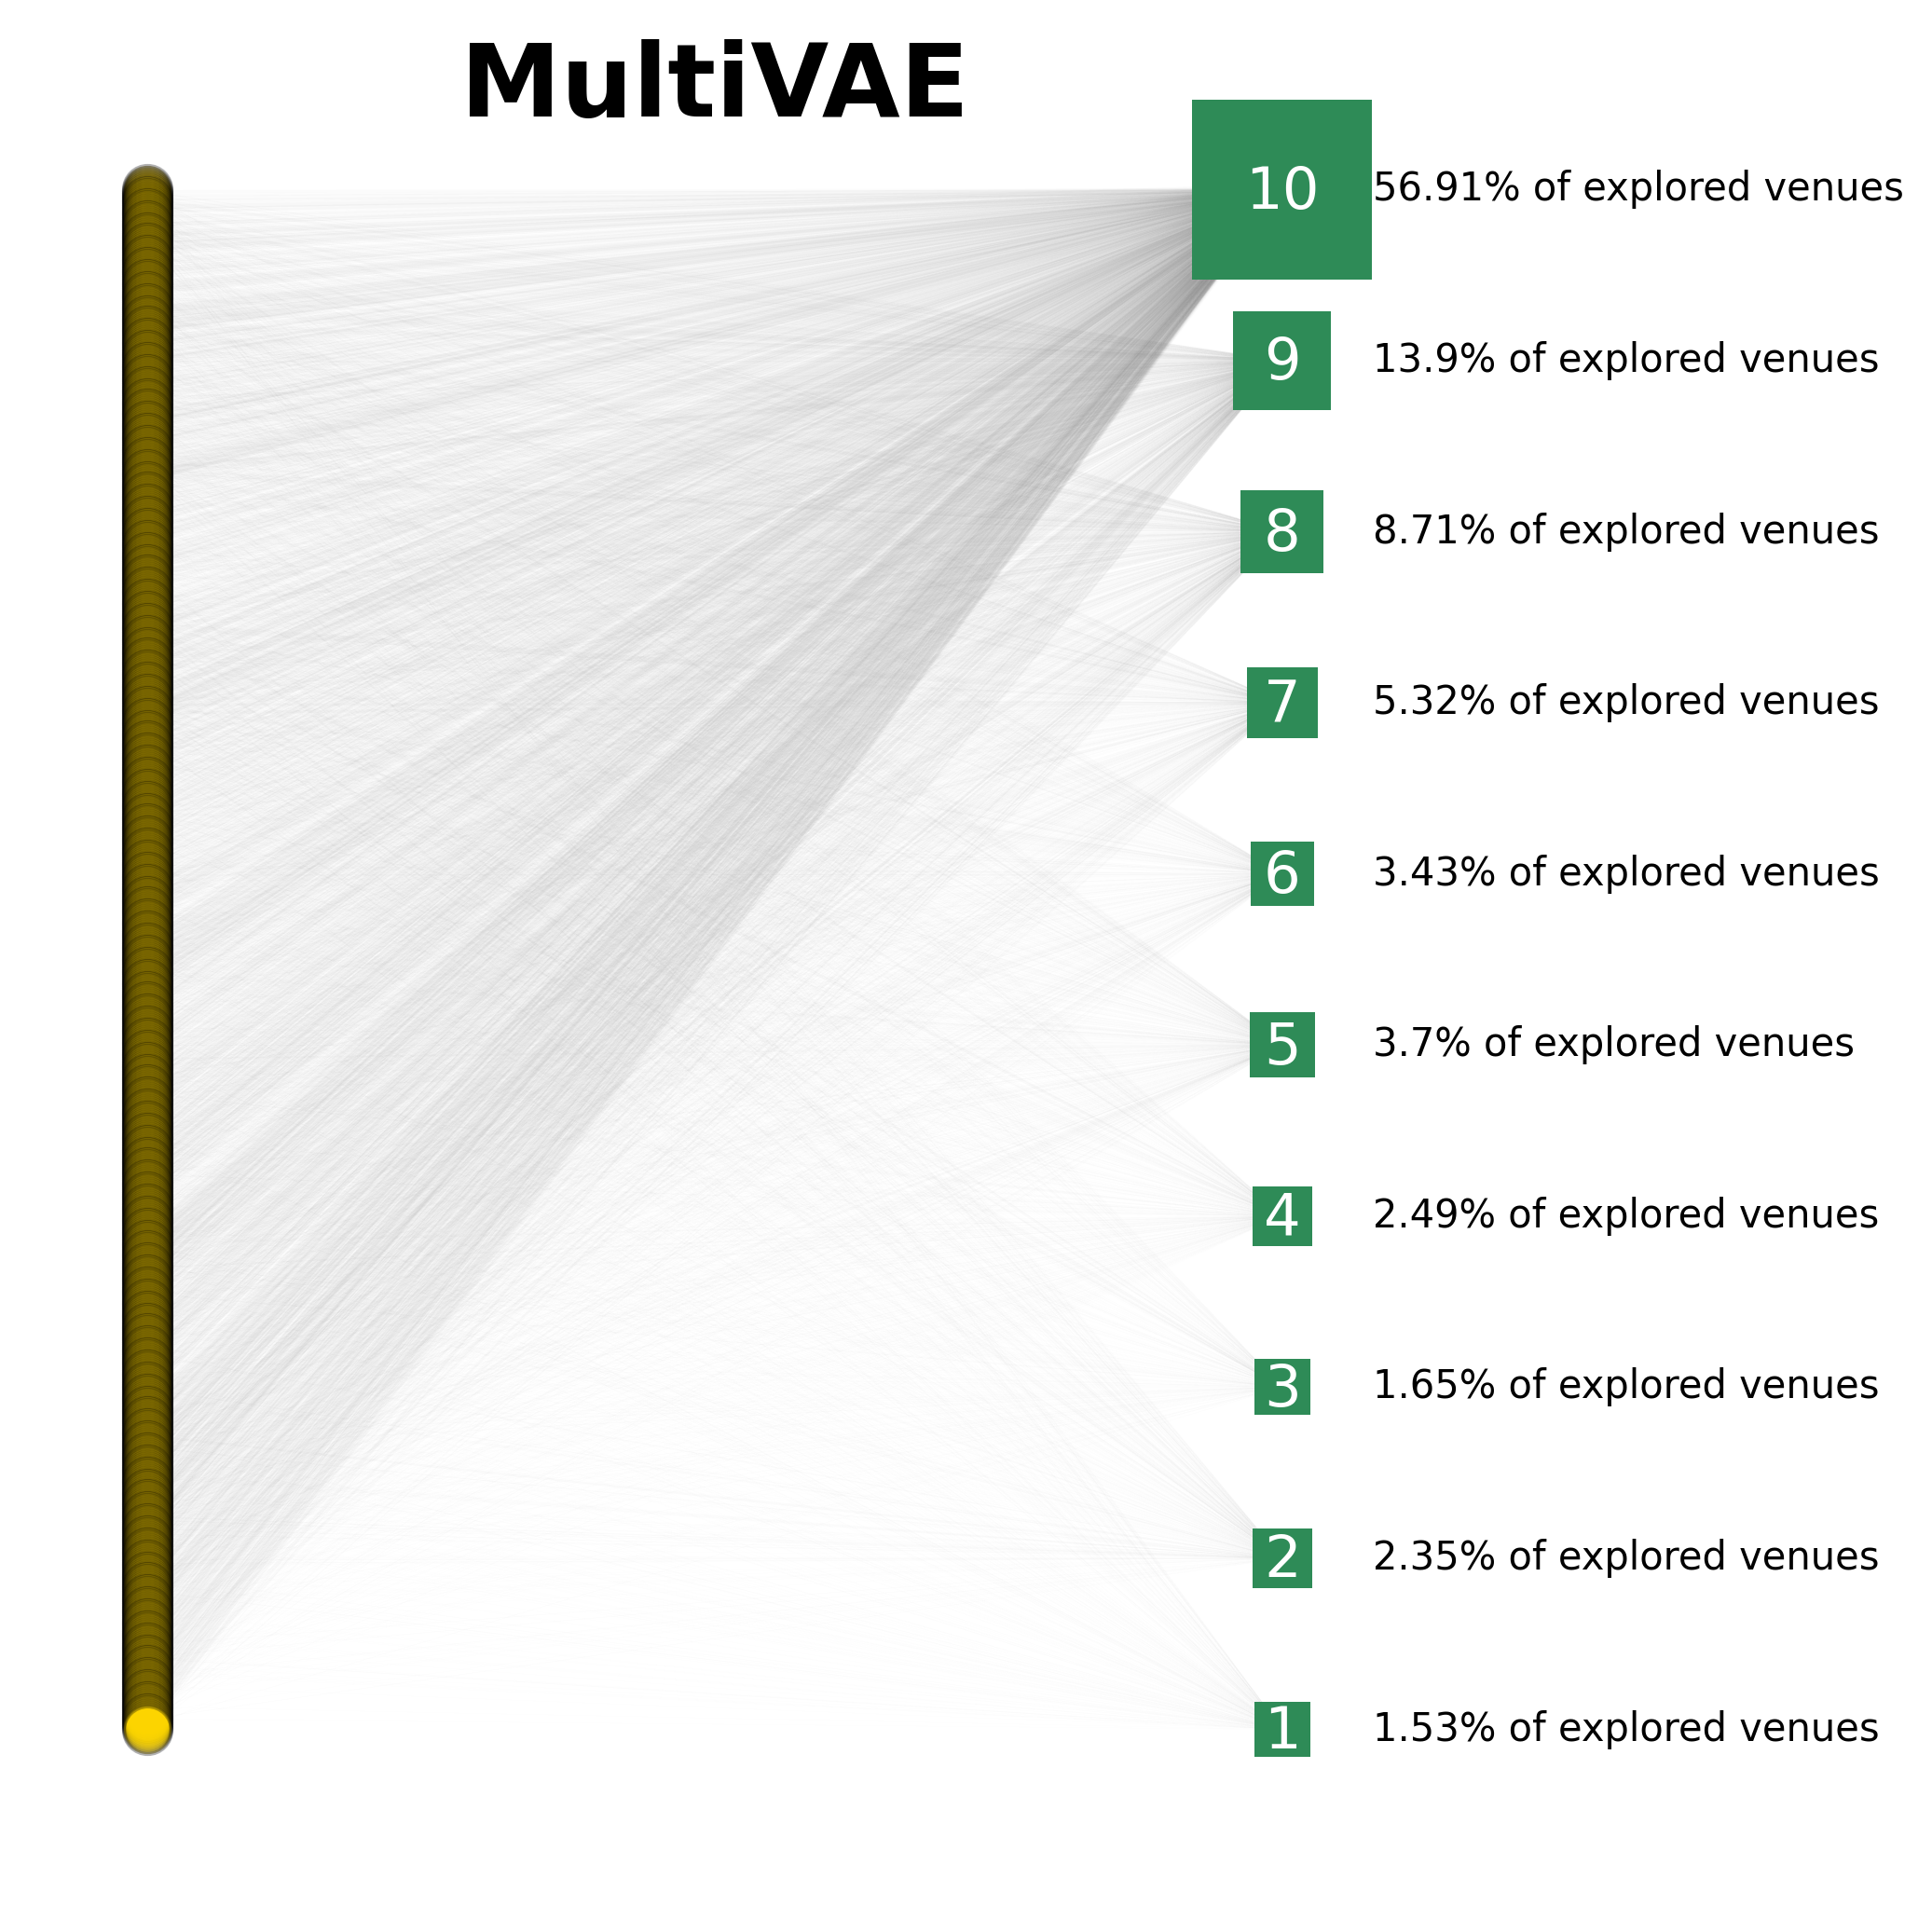

In [27]:
# Sample usage workflow:
# Step 1: Filter venues with at least 3 unique users
user_venue_counts_training = training_data.groupby(['uid', 'venueID']).size().reset_index(name='counts')
user_venue_counts_training.columns = ['uid', 'venueID', 'counts']

filtered_training = filter_venues_with_min_users(user_venue_counts_training, min_users=3)

user_venue_countsp1 = merged_user_histories_p1.groupby(['uid', 'venueID']).size().reset_index(name='counts')
filtered_p1 = user_venue_countsp1[user_venue_countsp1['venueID'].isin(filtered_training['venueID'].unique())]

# Step 2: Create venue deciles
venue_deciles = create_ranked_deciles(filtered_training)

# Step 3: Create exploration network graph
G, top_users, decile_weights = create_exploration_network(filtered_training, filtered_p1, venue_deciles)

# Step 4: Visualize the network
plot_exploration_network(G, top_users, decile_weights, p1_data=filtered_p1)

In [ ]:
def create_training_network(train_data, venue_deciles):
    """
    Creates a bipartite network showing historical user-venue interactions:
    - User nodes on the left side
    - Venue decile nodes (0-9) on the right side
    - Edges represent visits during the training period
    - Edge weights = number of venues in that decile visited by the user
    """
    # Create mapping from venue ID to its popularity decile
    venue_to_decile = dict(zip(venue_deciles['venueID'], venue_deciles['decile']))
    
    # Track which venues each user visited in training, organized by decile
    user_venue_by_decile = {}
    for _, row in train_data.iterrows():
        user, venue = row['uid'], row['venueID']
        decile = venue_to_decile.get(venue)
        if decile is not None:
            user_venue_by_decile.setdefault(user, {}).setdefault(decile, set()).add(venue)
    
    # Count unique venues visited by each user and sort users by activity level
    user_venue_counts = train_data.groupby('uid')['venueID'].nunique().to_dict()
    sorted_users = sorted(user_venue_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Count total venues visited in each decile (for node sizing)
    decile_counts = {d: 0 for d in range(10)}
    for user, _ in sorted_users:
        for decile, venues in user_venue_by_decile.get(user, {}).items():
            decile_counts[decile] += len(venues)
    
    # Create the graph
    G = nx.Graph()
    
    # Add user nodes
    for user, _ in sorted_users:
        G.add_node(str(user), bipartite=0)
    
    # Add decile nodes with size proportional to number of venues
    total_venues = sum(decile_counts.values())
    print("Total venues in training:", total_venues)
    
    for d in range(10):
        # Base size + proportional size based on venue count
        size = 150 + (decile_counts[d] / total_venues * 3500 if total_venues > 0 else 0)
        G.add_node(f"decile_{d}", bipartite=1, size=size)
    
    # Add edges between users and deciles
    for user, _ in sorted_users:
        for decile, venues in user_venue_by_decile.get(user, {}).items():
            G.add_edge(str(user), f"decile_{decile}", weight=len(venues))
    
    return G, sorted_users, decile_counts

def plot_training_network(G, top_users_with_counts, decile_weights):
    # top_users_with_counts = sorted_users (uid, venue_count)
    top_user_ids = [u for u, _ in top_users_with_counts]
    
    pos = {}
    user_y = np.linspace(1, 0, len(top_user_ids))
    for idx, user in enumerate(top_user_ids):
        pos[str(user)] = (0, user_y[idx])

    decile_nodes = [f"decile_{i}" for i in range(9, -1, -1)]
    decile_y = np.linspace(1, 0, len(decile_nodes))
    for idx, d in enumerate(decile_nodes):
        pos[d] = (1, decile_y[idx])
    
    plt.figure(figsize=(7, 7), dpi=300)
    
    # Disegniamo nodi user
    user_nodes = [n for n in G.nodes if not n.startswith('decile')]
    nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color='gold', node_size=150, alpha=0.3, edgecolors="black", linewidths=1, node_shape='o')
    
    # Disegniamo nodi decile
    sizes = [G.nodes[n]['size'] for n in decile_nodes]
    nx.draw_networkx_nodes(G, pos, nodelist=decile_nodes, node_color='royalblue', node_size=sizes, alpha=1, edgecolors="royalblue", linewidths=0, node_shape='s')
    
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    max_weight = max(weights) if weights else 1
    norm_weights = [w / max_weight * 5 for w in weights]
    nx.draw_networkx_edges(G, pos, width=norm_weights, edge_color='gray', alpha=0.02)
    
    labels = {n: n.split('_')[1] for n in decile_nodes}
    labels = {n: int(labels[n]) + 1 for n in decile_nodes}

    pos_labels = {n: (pos[n][0], pos[n][1]-0.002) for n in decile_nodes} 
    nx.draw_networkx_labels(G, pos_labels, labels=labels, font_size=15, font_color='white')

    
    # Stampa dei decile_weights a fianco
    for n in decile_nodes:
        d = int(n.split('_')[1])
        x, y = pos[n]
        count = decile_weights[d]
        #normalize by sum
        count = (count / sum(decile_weights.values())) * 100
        count = round(count, 2)
        plt.text(x + 0.08, y, f"{count}% of visited venues", fontsize=10, ha='left', va='center')
    
    plt.axis('off')
    plt.title(f"Training", fontsize=26, fontweight='bold', y=0.94)
    plt.tight_layout()
    plt.savefig(f"figures/{algorithm}_training_network.pdf", bbox_inches='tight', dpi=500)
    plt.show()




Venue totali prima: 27413
Venue con almeno 3 utenti unici: 5414

📊 Venue Decile Distribution (rank + qcut)

Decile | Venue Count | User Uniques (min–max)
-------|--------------|-------------------------
   0    |    542       |    3 – 3
   1    |    541       |    3 – 3
   2    |    541       |    3 – 3
   3    |    542       |    3 – 4
   4    |    541       |    4 – 4
   5    |    541       |    4 – 5
   6    |    542       |    5 – 6
   7    |    541       |    6 – 7
   8    |    541       |    7 – 10
   9    |    542       |    10 – 153
Total venues in training: 33158


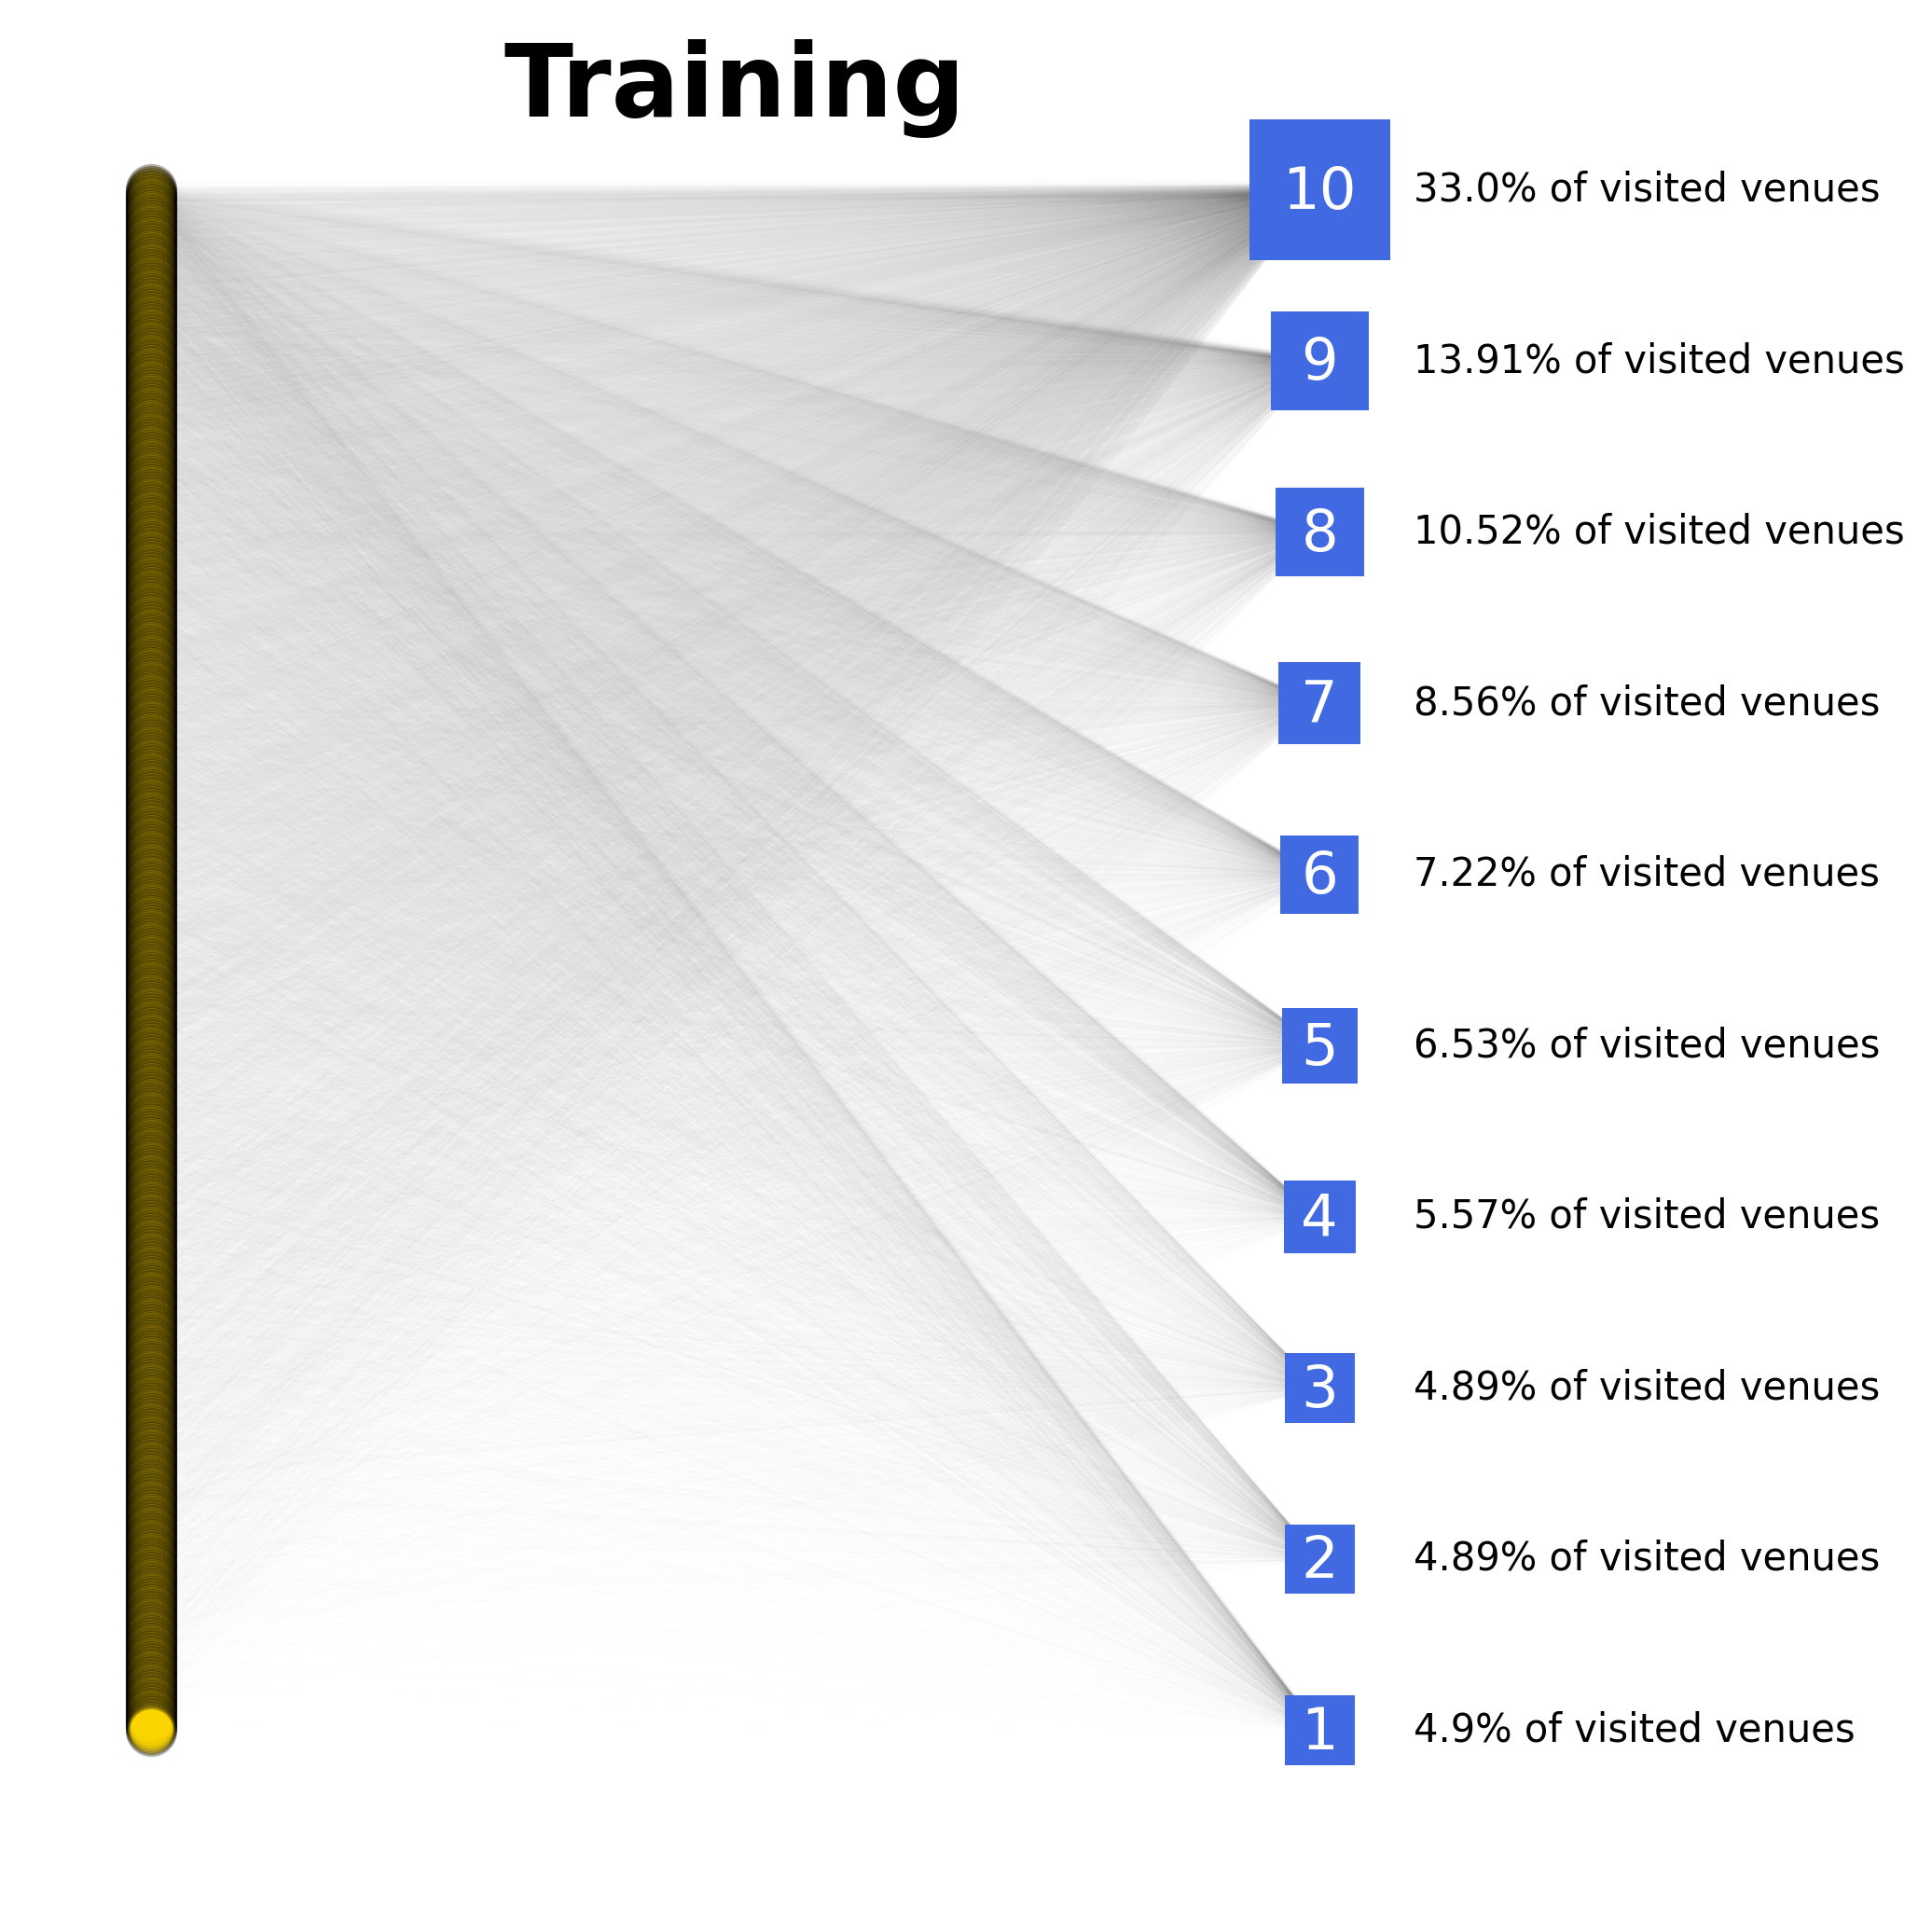

In [29]:
filtered_training = filter_venues_with_min_users(user_venue_counts_training, min_users=3)
venue_deciles = create_ranked_deciles(filtered_training)

G_train, sorted_users_train, decile_weights_train = create_training_network(filtered_training, venue_deciles)
plot_training_network(G_train, sorted_users_train, decile_weights_train)


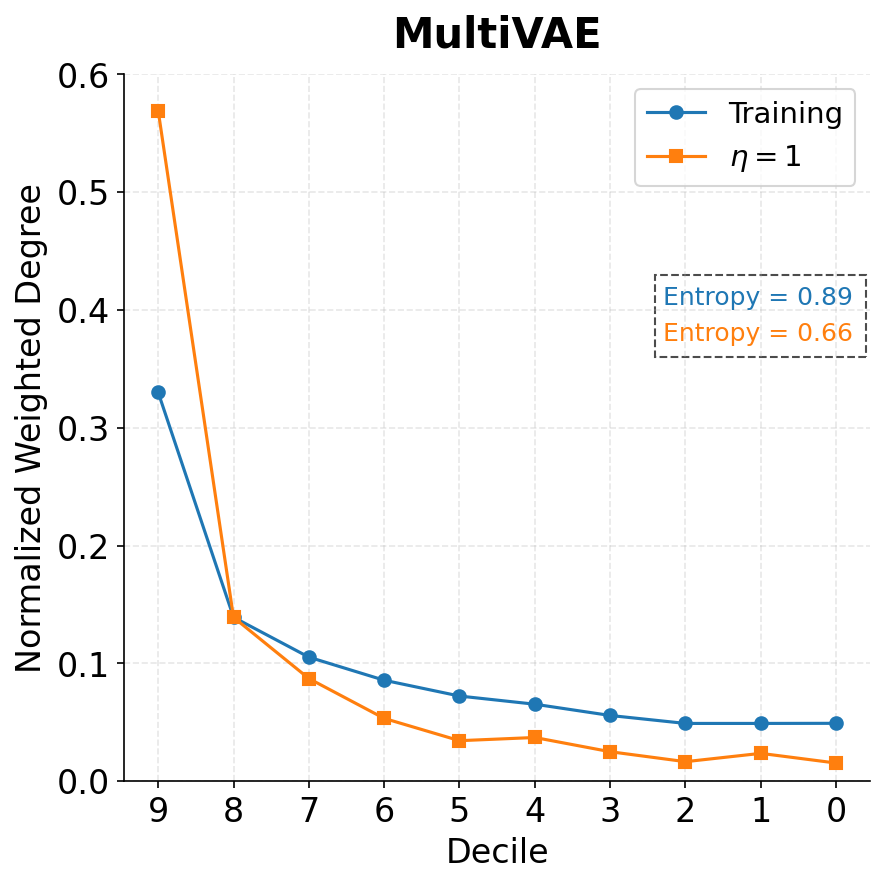

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_decile_weights_normalized_by_sum(decile_weights_train, decile_weights_p1, title="Decile Weights (Normalized by Sum)"):
    # Decile da 0..9 sull'asse X
    deciles = list(range(10))  # 0, 1, 2, ..., 9
    
    # Ricavo i valori (nell'ordine 0..9)
    train_vals = [decile_weights_train.get(d, 0) for d in deciles]
    p1_vals = [decile_weights_p1.get(d, 0) for d in deciles]
    
    # Calcolo la somma
    sum_train = sum(train_vals) if train_vals else 1
    sum_p1 = sum(p1_vals) if p1_vals else 1
    
    # Normalizzo i valori
    norm_train = [v / sum_train for v in train_vals]
    norm_p1 = [v / sum_p1 for v in p1_vals]
    
    plt.figure(figsize=(6, 6), dpi=150)

    entropy_p1 = - sum((v/sum_p1) * np.log2(v/sum_p1) for v in p1_vals if v > 0)
    norm_entropy_p1 = entropy_p1 / np.log2(len(p1_vals))

    entropy_train = - sum((v/sum_train) * np.log2(v/sum_train) for v in train_vals if v > 0)
    norm_entropy_train = entropy_train / np.log2(len(train_vals))


    
    # Inverti l'asse x completamente
    plt.gca().invert_xaxis()
    
    # Scatter per Training
    plt.plot(deciles, norm_train, marker='o', label='Training')
    # Scatter per P1
    plt.plot(deciles, norm_p1, marker='s', label=r'$\eta=1$')
    
    plt.ylim (0, 0.6)
    
    # Create a rectangle with a colored edge to contain the text
    rect = plt.Rectangle((-0.4, 0.36), 2.8, 0.07, facecolor='white', alpha=0.7, 
                        edgecolor='black', linewidth=1, linestyle='--')
    plt.gca().add_patch(rect)
    # Add the text elements inside the rectangle
    plt.text(2.3, 0.38, f"Entropy = {norm_entropy_p1:.2f}", fontsize=12, ha='left', 
            va='center', color="C1")
    plt.text(2.3, 0.41, f"Entropy = {norm_entropy_train:.2f}", fontsize=12, ha='left', 
            va='center', color="C0")
    # Aumenta la dimensione dei tick labels
    plt.xticks(deciles, fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.xlabel('Decile', fontsize=16)
    plt.ylabel('Normalized Weighted Degree', fontsize=16)
    plt.legend(fontsize=14, loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.title(f"{algorithm}", fontsize=20, fontweight='bold', y=1.02)
    
    # Rimuovi asse sopra e destra
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()


plot_decile_weights_normalized_by_sum(decile_weights_train, decile_weights, title="Decile Weights (Train vs P1)")

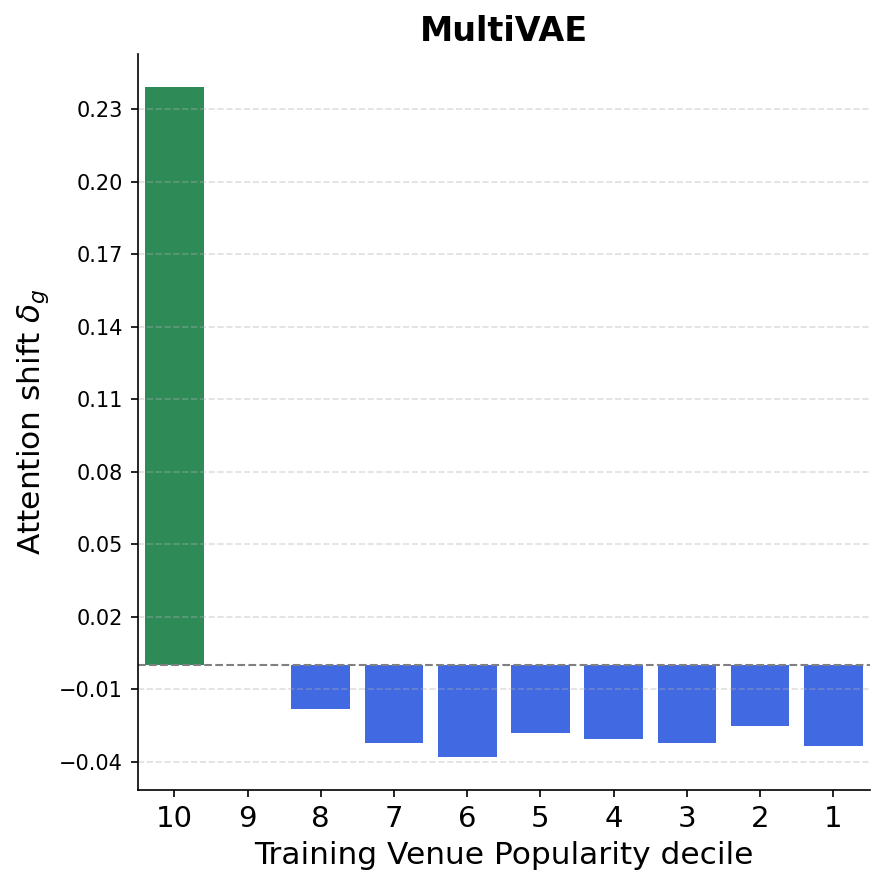

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_decile_diff_hist(decile_weights_train, decile_weights_p1, title="Δ Normalized Weighted Degree (P1 - Training)"):
    """
    Plotta la differenza normalizzata tra P1 e Training come istogramma:
    verde se positiva, rosso se negativa.
    """
    deciles = list(range(10))  # 0..9

    # Estrai valori
    train_vals = [decile_weights_train.get(d, 0) for d in deciles]
    p1_vals = [decile_weights_p1.get(d, 0) for d in deciles]

    # Normalizza per somma
    sum_train = sum(train_vals) if train_vals else 1
    sum_p1 = sum(p1_vals) if p1_vals else 1

    norm_train = [v / sum_train for v in train_vals]
    norm_p1 = [v / sum_p1 for v in p1_vals]

    # Differenza (P1 - Train)
    diff_vals = [p1 - train for p1, train in zip(norm_p1, norm_train)]

    # Colori: verde se positiva, rosso se negativa
    colors = ['seagreen' if diff > 0 else 'royalblue' for diff in diff_vals]

    # Inverti i dati per la visualizzazione
    deciles_reversed = deciles[::-1]
    diff_vals_reversed = diff_vals[::-1]
    colors_reversed = colors[::-1]

    plt.figure(figsize=(6, 6), dpi=150)

    # Usa l'ordine invertito dei decili come posizioni
    bars = plt.bar(deciles_reversed, diff_vals_reversed, color=colors_reversed, width=0.8)

    plt.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Imposta i tick e le etichette manualmente nell'ordine inverso
    plt.xticks(deciles_reversed, deciles_reversed, fontsize=14)

    # Prova a impostare i tick esplicitamente
    ax = plt.gca()
    ax.set_xticks(deciles_reversed)
    ax.set_xticklabels([d+1 for d in deciles_reversed], fontsize=14)  # Just change the labels

    # Imposta i limiti dell'asse x
    ax.set_xlim(max(deciles) + 0.5, min(deciles) - 0.5)
    
    #set yticklabels to be 2 decimal and every 0.02
    min_neg = min(diff_vals_reversed)
    max_pos = max(diff_vals_reversed)
    #round to 2 decimal
    min_neg = round(min_neg, 2)
    max_pos = round(max_pos, 2)

    # Set the y-ticks to be every 0.02
    y_ticks = np.arange(min_neg, max_pos, 0.03)
    # Round to 2 decimal
    y_ticks = np.round(y_ticks, 2)
    # Set the y-ticks
    ax.set_yticks(y_ticks)

    plt.xlabel("Training Venue Popularity decile", fontsize=15)
    plt.ylabel(r"Attention shift $\delta_g$", fontsize=15)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.4)

    # Rimuovi spigoli top e right
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig(f"{algorithm}_diff_hist.pdf", bbox_inches='tight', dpi=300)
    plt.show()



# CHIAMATA DELLA FUNZIONE
plot_decile_diff_hist(decile_weights_train, decile_weights, title=f"{algorithm}")

Venue totali prima: 27413
Venue con almeno 3 utenti unici: 5414

📊 Venue Centile Distribution

Centile | Venue Count | User Uniques (min–max)
--------|-------------|-------------------------
    0   |     55      |    3 – 3
    1   |     54      |    3 – 3
    2   |     54      |    3 – 3
    3   |     54      |    3 – 3
    4   |     54      |    3 – 3
    5   |     54      |    3 – 3
    6   |     54      |    3 – 3
    7   |     55      |    3 – 3
    8   |     54      |    3 – 3
    9   |     54      |    3 – 3
   10   |     54      |    3 – 3
   11   |     54      |    3 – 3
   12   |     54      |    3 – 3
   13   |     54      |    3 – 3
   14   |     54      |    3 – 3
   15   |     55      |    3 – 3
   16   |     54      |    3 – 3
   17   |     54      |    3 – 3
   18   |     54      |    3 – 3
   19   |     54      |    3 – 3
   20   |     54      |    3 – 3
   21   |     54      |    3 – 3
   22   |     54      |    3 – 3
   23   |     55      |    3 – 3
   24   |     54 

/tmp/ipykernel_1918635/4275234339.py:162: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(v)}" for v in ax.get_yticks()], fontsize=14)


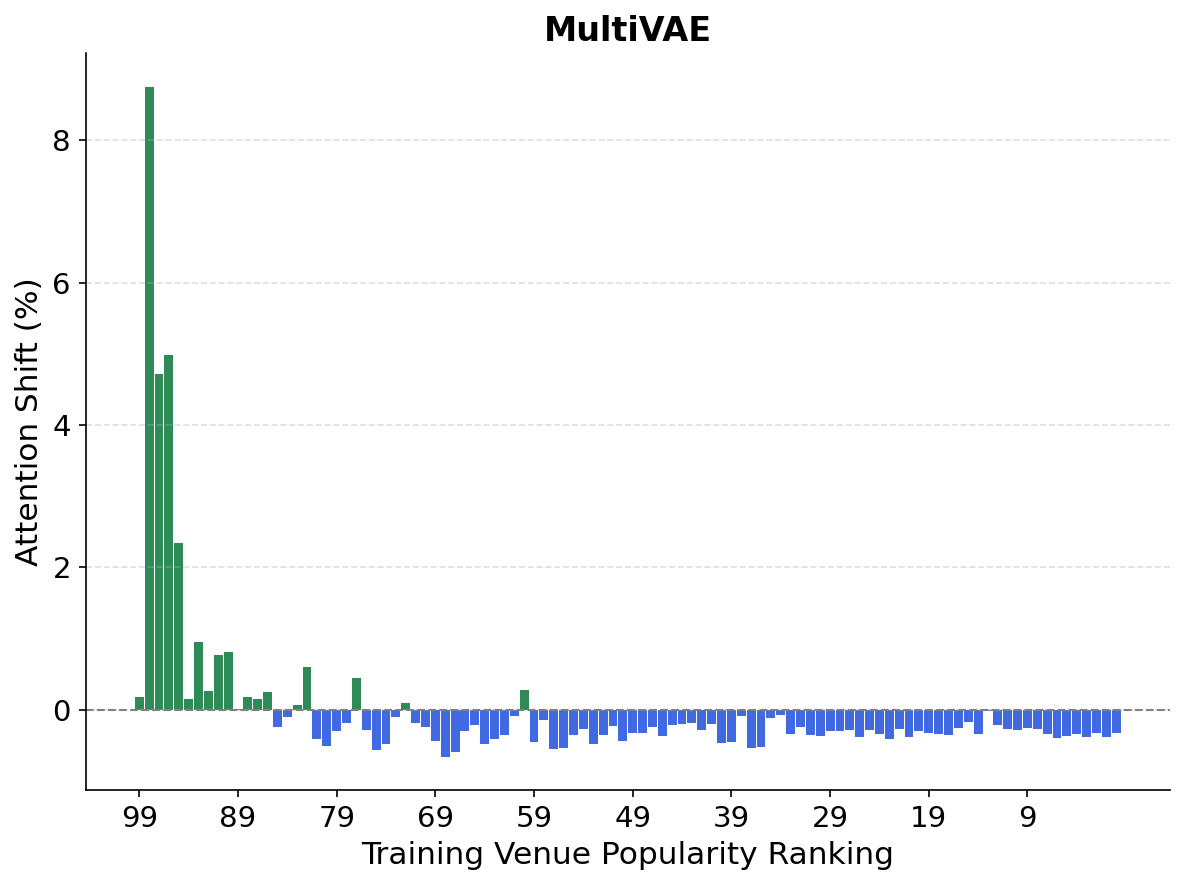

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# === STEP 1: FILTER VENUES ===
def filter_venues_with_min_users(user_venue_data, min_users=3):
    venue_user_counts = user_venue_data.groupby('venueID')['uid'].nunique()
    valid_venues = venue_user_counts[venue_user_counts >= min_users].index
    filtered = user_venue_data[user_venue_data['venueID'].isin(valid_venues)].copy()

    print(f"Venue totali prima: {user_venue_data['venueID'].nunique()}")
    print(f"Venue con almeno {min_users} utenti unici: {len(valid_venues)}")

    return filtered

# === STEP 2: CENTILES FOR VENUES ===
def create_ranked_centiles(user_venue_data, n_bins=100):
    """
    Creates centiles (100 bins) instead of deciles (10 bins) for venue popularity
    """
    venue_user_counts = user_venue_data.groupby('venueID')['uid'].nunique().reset_index()
    venue_user_counts.columns = ['venueID', 'unique_users']
    
    venue_user_counts['rank'] = venue_user_counts['unique_users'].rank(method='first')
    venue_user_counts['centile'] = pd.qcut(venue_user_counts['rank'], q=n_bins, labels=False)

    # Print stats for all centiles
    stats = venue_user_counts.groupby('centile')['unique_users'].agg(['min', 'max', 'count'])
    
    print("\n📊 Venue Centile Distribution\n")
    print("Centile | Venue Count | User Uniques (min–max)")
    print("--------|-------------|-------------------------")
    for centile, row in stats.iterrows():
        print(f"  {centile:>3}   |  {row['count']:>5}      |    {int(row['min'])} – {int(row['max'])}")
    
    # Verify total venue count
    total_venues = len(venue_user_counts)
    print(f"\nTotal unique venues: {total_venues}")

    return venue_user_counts[['venueID', 'centile', 'unique_users']]

# === STEP 3: CREATE EXPLORATION NETWORK WITH CENTILES ===
def create_exploration_network_centiles(train_data, p1_data, venue_centiles):
    """
    Creates counts of user-venue relationships by centile
    - Each user-venue pair counts once
    - If multiple users visit the same venue, each counts separately
    """
    # Create mapping from venue ID to its popularity centile
    venue_to_centile = dict(zip(venue_centiles['venueID'], venue_centiles['centile']))
    
    # Create a set of all user-venue pairs from training data for efficient lookup
    train_set = set(zip(train_data['uid'], train_data['venueID']))
    
    # Track which new venues each user explored, organized by centile
    user_new_venues = {}
    for _, row in p1_data.iterrows():
        user, venue = row['uid'], row['venueID']
        # Only consider venues that are new to the user and exist in our centile mapping
        if (user, venue) not in train_set and venue in venue_to_centile:
            centile = venue_to_centile[venue]
            user_new_venues.setdefault(user, {}).setdefault(centile, set()).add(venue)
    
    # Count total user-venue relationships by centile
    centile_counts = {i: 0 for i in range(100)}
    user_venue_pairs_count = 0
    
    for user, user_data in user_new_venues.items():
        for centile, venues in user_data.items():
            # Count each user-venue relationship
            centile_counts[centile] += len(venues)
            user_venue_pairs_count += len(venues)
    
    # Get user activity info
    p1_unique_venues = p1_data.groupby('uid')['venueID'].nunique().to_dict()
    sorted_users = sorted(p1_unique_venues.items(), key=lambda x: x[1], reverse=True)
    
    print(f"Total user-venue relationships in exploration: {user_venue_pairs_count}")
    
    return sorted_users, centile_counts

# === STEP 4: CREATE TRAINING NETWORK WITH CENTILES ===
def create_training_network_centiles(train_data, venue_centiles):
    """
    Creates counts of user-venue relationships by centile for training data
    """
    # Create mapping from venue ID to its popularity centile
    venue_to_centile = dict(zip(venue_centiles['venueID'], venue_centiles['centile']))
    
    # Track which venues each user visited in training, organized by centile
    user_venue_by_centile = {}
    for _, row in train_data.iterrows():
        user, venue = row['uid'], row['venueID']
        if venue in venue_to_centile:
            centile = venue_to_centile[venue]
            user_venue_by_centile.setdefault(user, {}).setdefault(centile, set()).add(venue)
    
    # Count user-venue relationships by centile
    centile_counts = {c: 0 for c in range(100)}
    user_venue_pairs_count = 0
    
    for user, user_data in user_venue_by_centile.items():
        for centile, venues in user_data.items():
            # Each user-venue relationship counts once
            centile_counts[centile] += len(venues)
            user_venue_pairs_count += len(venues)
    
    # Get user activity info
    user_venue_counts = train_data.groupby('uid')['venueID'].nunique().to_dict()
    sorted_users = sorted(user_venue_counts.items(), key=lambda x: x[1], reverse=True)
    
    print(f"Total user-venue relationships in training: {user_venue_pairs_count}")
    
    return sorted_users, centile_counts

def plot_centile_diff_hist(centile_weights_train, centile_weights_p1, title="Popularity Shift by Centile"):
    """
    Plot the normalized difference between P1 and Training centiles as histogram.
    Shows differences as percentages.
    """
    centiles = list(range(100))  # 0..99 for centiles

    # Extract values
    train_vals = [centile_weights_train.get(c, 0) for c in centiles]
    p1_vals = [centile_weights_p1.get(c, 0) for c in centiles]

    # Normalize by sum to get percentages
    sum_train = sum(train_vals) if train_vals else 1
    sum_p1 = sum(p1_vals) if p1_vals else 1

    norm_train = [v / sum_train * 100 for v in train_vals]  # Convert to percentages
    norm_p1 = [v / sum_p1 * 100 for v in p1_vals]           # Convert to percentages

    # Difference (P1 - Train) in percentage points
    diff_vals = [p1 - train for p1, train in zip(norm_p1, norm_train)]
    
    # Colors: green if positive, blue if negative
    colors = ['seagreen' if diff > 0 else 'royalblue' for diff in diff_vals]
    
    # Reverse for plotting
    centiles_reversed = centiles[::-1]
    diff_vals_reversed = diff_vals[::-1]
    colors_reversed = colors[::-1]
    
    # For x-axis labels, select about 10 points evenly distributed
    step = 10  # Show every 10th centile
    x_positions = range(0, len(centiles_reversed), step)
    x_labels = [centiles_reversed[i] for i in x_positions]

    plt.figure(figsize=(8, 6), dpi=150)

    # Plot bars
    bars = plt.bar(range(len(diff_vals_reversed)), diff_vals_reversed, color=colors_reversed, width=0.9)

    plt.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Set up x-axis
    ax = plt.gca()
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, fontsize=14)
    ax.set_yticklabels([f"{int(v)}" for v in ax.get_yticks()], fontsize=14)

    plt.yticks(fontsize=14)
    plt.xlabel("Training Venue Popularity Ranking", fontsize=15)
    plt.ylabel("Attention Shift (%)", fontsize=15)  # Clean, publication-ready label
    plt.title(title, fontsize=16, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.4)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig(f"figures/{algorithm}_centile_diff_hist.pdf", bbox_inches='tight', dpi=300)
    plt.show()

# === EXAMPLE USAGE ===
def run_centile_analysis(algorithm_name="Algorithm"):
    
    # STEP 1: Filter venues with minimum user count
    user_venue_counts_training = training_data.groupby(['uid', 'venueID']).size().reset_index(name='counts')
    user_venue_counts_training.columns = ['uid', 'venueID', 'counts']
    
    filtered_training = filter_venues_with_min_users(user_venue_counts_training, min_users=3)
    
    user_venue_countsp1 = merged_user_histories_p1.groupby(['uid', 'venueID']).size().reset_index(name='counts')
    filtered_p1 = user_venue_countsp1[user_venue_countsp1['venueID'].isin(filtered_training['venueID'].unique())]
    
    # STEP 2: Create venue centiles (100 bins)
    venue_centiles = create_ranked_centiles(filtered_training, n_bins=100)
    
    # STEP 3: Create centile-based networks
    sorted_users_train, centile_weights_train = create_training_network_centiles(filtered_training, venue_centiles)
    sorted_users_p1, centile_weights_p1 = create_exploration_network_centiles(filtered_training, filtered_p1, venue_centiles)
    
    # STEP 4: Plot difference histogram
    plot_centile_diff_hist(centile_weights_train, centile_weights_p1, 
                          title=f"{algorithm_name}")
    
    return centile_weights_train, centile_weights_p1

centile_weights_train, centile_weights_p1 = run_centile_analysis(algorithm)

In [ ]:
#normalize centile_weights_train bu sum
centile_weights_train = {k: v / sum(centile_weights_train.values()) for k, v in centile_weights_train.items()}
centile_weights_p1 = {k: v / sum(centile_weights_p1.values()) for k, v in centile_weights_p1.items()}

In [ ]:
diff_dict = {k: centile_weights_p1[k] - centile_weights_train[k] for k in centile_weights_train.keys()}
#get the sum of the values
somma = sum(v for v in diff_dict.values()) 
somma

1.249000902703301e-16

In [ ]:
somma_train = sum(v for v in centile_weights_train.values())
sommap1 = sum(v for v in centile_weights_p1.values())
somma_train, sommap1

(1.0, 0.9999999999999999)